# CS 4993 Independent Study – Deep Learning with COVID Data

***Professor: [Haiyang Shen](https://engineering.virginia.edu/faculty/haiying-shen)***  
***Researcher: [Iain Muir](https://www.linkedin.com/in/iain-muir-b37718164/) | iam9ez***

*Github Project:* https://github.com/iainmuir6/machineLearning_covidData  
*Last Updated: June 30th, 2021*  

## Table of Contents <a class="anchor" id="toc"></a>
* **[0. Import Packages](#setup)**
    * [0.1 General Imports](#imp1)
    * [0.2 ML Imports](#imp2)
* **[1. Read Excel File](#data)**
    * [1.1 Data Overview](#overview)
    * [1.2 Descriptive Statistics](#stats)
    * [1.3 Inspect Null Data](#null)
* **[2. Data Preparation](#prep)**
    * [2.1 Drop Columns](#drop)
    * [2.2 Handle Categorical Variables](#handle1)
        * *[2.2.1 Manual Conversion](#manual)*
        * *[2.2.2 Encoding](#encoding)*
        * *[2.2.3 Categorical Codes](#codes)*
    * [2.3 Handle Missing Values](#handle2)
    * [2.4 Feature Scaling](#scaling)
    * [2.5 Train / Test Split](#split)
    * [2.6 Final Prepared Data](#final_data)
* **[3. Feature Selection I](#feature)**
    * [3.1 Pearson Correlation](#corr)
    * [3.2 Chi-Squared Test](#chi_sq)
    * [3.3 Recursive Feature Elimination](#rfe)
    * [3.4 SelectFromModel: Lasso](#lasso)
    * [3.5 SelectFromModel: Random Forest Classifier](#rfc)
    * [3.6 Cumulative Feature Selection](#cum)
* **[4. Model Selection](#model)**
    * [4.1 Train / Test Data](#tt)
    * [4.2 Model Evaluation Functions](#funcs)
    * [4.3 Model Construction](#models)
        * *[4.3.1 Decision Tree](#dt)*
        * *[4.3.2 Random Forest Classifier](#rfc2)*
        * *[4.3.3 K-Nearest Neighbors Classifier](#knn)*
        * *[4.3.4 Deep Neural Network](#dnn)*
        * *[4.3.5 Convolutional Neural Network](#cnn)*
        * *[4.3.6 Recurrent Neural Network](#rnn)*
    * [4.4 Simultaneous Model Evaluation](#eval)
    * [4.5 RandomizedSearch](#search)
* **[5. Generative Adverserial Networks](#gan)**
    * [5.1 Network Setup](#setup2)
    * [5.2 Training GAN Models](#train)
        * [5.2.1 GAN](#gan2)
        * [5.2.2 CGAN](#cgan)
        * [5.2.3 WGAN + WCGAN](#wgan)
    * [5.3 Loss Information](#loss)
    * [5.4 Generate New Data](#new_data)
    * [5.5 Training Models on New Data](#train_gan)
    * [5.6 Plot Real vs Test Data](#plot)
    * [5.7 Feature Importance](#importance)
* **[6. Retrain Models with GAN Data](#retrain)**
    * [6.1 Re-Prepare Data](#prep2)
    * [6.2 Re-Train Models](#retrain2)
* **[7. Final Model Training with Feature Selection](#final)**
    * [7.1 Define Models and Variables](#define)
    * [7.2 Model Performance w/o GAN](#perf1)
    * [7.3 Model Performance with GAN](#perf2)
* **[8. Figures for Final Report](#figures)**

## 0. Import Packages <a class="anchor" id="setup"></a>

[Table of Contents](#toc)

#### 0.1 General Imports <a class="anchor" id="imp1"></a>

In [1]:
from IPython.display import Markdown, Image, display
import matplotlib.gridspec as gridspec
from scipy.stats import reciprocal
import matplotlib.pyplot as plt
from matplotlib import cm
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import itertools
import pickle
import random
import os

#### 0.2 ML Imports <a class="anchor" id="imp2"></a>

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions
from ann_visualizer.visualize import ann_viz
from sklearn.externals.six import StringIO
import pydotplus
import sklearn

from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, Embedding, SimpleRNN, LSTM, GRU
from keras.layers import LeakyReLU, PReLU, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import tensorflow.compat.v1 as tf
from tensorflow import keras
tf.disable_v2_behavior()

import xgboost as xgb
from GAN import GAN

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
tf.__version__

'2.3.0'

In [4]:
keras.__version__

'2.4.0'

In [5]:
sklearn.__version__

'0.21.2'

In [6]:
SEED = 0

In [ ]:
show_data = False

## 1. Read Excel File <a class="anchor" id="data"></a>

[Table of Contents](#toc)

#### 1.1 Data Overview <a class="anchor" id="overview"></a>

In [7]:
df = pd.read_excel('ed_pred.xlsx')
df = df.reset_index()
if show_data:
    df.head(5)

,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26,31,2.5,82.0,14,26.0,80.0,8.5,4.3,0.5
1,1,2,0,NaN,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,19,11,0.9,83.0,73,NaN,100.0,8.1,4.6,0.6
2,2,3,0,NaN,None Detected,55,African American,Non-Hispanic,Male,83.0,...,23,9,1.2,123.0,26,29.0,106.0,7.1,4.0,0.7
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,30,45,1.6,297.0,22,NaN,78.0,7.8,3.7,0.5
4,4,5,0,NaN,None Detected,67,African American,Non-Hispanic,Female,90.0,...,27,25,1.0,96.0,12,18.0,122.0,7.4,3.5,0.2


In [8]:
df.shape

(7380, 41)

In [9]:
target = 'COVIDResult'
df.columns

Index(['index', 'patno', 'Admitted', 'AdmittingDepartment', 'COVIDResult',
       'Age', 'FirstRace', 'Ethnicity', 'Sex', 'heart_rate', 'sbp', 'dbp',
       'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit',
       'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c',
       'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc',
       'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c',
       'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride',
       'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose',
       'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein',
       'cmp_albumin', 'cmp_bilirubin'],
      dtype='object')

###### Column Description
Note (src - [Walk-In-Lab](https://www.walkinlab.com/products/view/complete-blood-count-cbc-comprehensive-metabolic-panel-cmp-14-blood-test-panel#:~:text=A%20CBC%20also%20helps%20your,anemia%2C%20and%20several%20other%20disorders.&text=Comprehensive%20Metabolic%20Panel%20)): 

CBC == [Complete Blood Count](https://www.mayoclinic.org/tests-procedures/complete-blood-count/about/pac-20384919)
* Complete Blood Count (CBC) gives important information about the numbers and kinds of cells in the blood, especially red blood cells, white blood cells, and platelets. A CBC helps your health professional check any symptoms, such as fatigue, weakness, or bruising, that you may have. A CBC also helps your health professional diagnose conditions, such as infection, anemia, and several other disorders.

CMP == [Comprehensive Metabolic Panel](https://www.mayocliniclabs.com/test-catalog/Clinical+and+Interpretive/113631)
* Comprehensive Metabolic Panel (CMP-14) with eGFR is a group of 14 laboratory tests ordered to give information about the current status of your liver, kidneys, and electrolyte and acid/base balance.  The test gives the current status of your blood sugar and blood proteins also.

#### 1.2 Descriptive Statistics <a class="anchor" id="stats"></a>

In [10]:
if show_data:
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     7380 non-null   int64  
 1   patno                     7380 non-null   int64  
 2   Admitted                  7380 non-null   int64  
 3   AdmittingDepartment       3003 non-null   object 
 4   COVIDResult               7380 non-null   object 
 5   Age                       7380 non-null   int64  
 6   FirstRace                 7379 non-null   object 
 7   Ethnicity                 7380 non-null   object 
 8   Sex                       7380 non-null   object 
 9   heart_rate                7352 non-null   float64
 10  sbp                       7292 non-null   float64
 11  dbp                       7292 non-null   float64
 12  pulse_ox                  7346 non-null   float64
 13  resp_rate                 7312 non-null   float64
 14  height  

In [11]:
if show_data:
    df.describe()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
count,7380.000000,7380.000000,7380.000000,7380.000000,7352.000000,7292.000000,7292.000000,7346.000000,7312.000000,456.000000,...,3874.000000,3872.000000,6286.000000,5570.000000,6286.000000,6286.000000,4767.000000,5399.000000,5175.000000,5402.000000
mean,3689.500000,3690.500000,0.406911,48.977642,94.529788,135.998354,76.034696,97.064661,21.029130,65.971491,...,0.740428,1.492485,137.104677,4.043447,102.562997,137.406141,55.627858,114.154843,7.210473,3.846113
std,2130.566826,2130.566826,0.491291,23.525661,23.352438,27.256409,15.302797,3.832935,6.762566,7.635750,...,0.545253,2.276703,4.366669,0.603037,5.600923,92.857337,154.142598,89.983238,0.843891,0.577974
min,0.000000,1.000000,0.000000,0.000000,0.000000,46.000000,0.000000,25.000000,0.000000,2.000000,...,0.000000,0.000000,107.000000,2.000000,60.000000,22.000000,7.000000,21.000000,2.400000,1.000000
25%,1844.750000,1845.750000,0.000000,31.000000,78.000000,118.000000,65.000000,96.000000,18.000000,63.000000,...,0.460000,0.100000,135.000000,3.700000,100.000000,94.000000,23.000000,71.000000,6.700000,3.500000
50%,3689.500000,3690.500000,0.000000,52.000000,92.000000,133.000000,75.000000,98.000000,20.000000,67.000000,...,0.670000,0.800000,138.000000,4.000000,103.000000,109.000000,31.000000,90.000000,7.200000,3.900000
75%,5534.250000,5535.250000,1.000000,67.000000,107.000000,151.000000,86.000000,99.000000,22.000000,70.000000,...,0.940000,2.000000,140.000000,4.300000,106.000000,140.000000,46.000000,123.000000,7.700000,4.200000
max,7379.000000,7380.000000,1.000000,119.000000,235.000000,258.000000,147.000000,100.000000,111.000000,77.000000,...,17.790000,41.100000,182.000000,8.900000,143.000000,1576.000000,6479.000000,1126.000000,11.300000,6.300000


In [12]:
if show_data:
    df.corr()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
index,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
patno,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
Admitted,-0.030377,-0.030377,1.000000,0.259000,0.071533,-0.034520,-0.083964,-0.187805,0.141345,0.006556,...,0.090950,-0.122416,-0.139857,0.123330,-0.145144,0.125331,0.098732,0.117501,-0.169298,-0.301735
Age,-0.071132,-0.071132,0.259000,1.000000,-0.343054,0.255632,0.021500,-0.233759,-0.128765,0.237857,...,-0.068070,-0.003148,-0.077553,0.129890,-0.137116,0.097948,-0.014016,-0.091849,-0.147716,-0.312481
heart_rate,-0.014543,-0.014543,0.071533,-0.343054,1.000000,-0.128325,0.032385,-0.018398,0.397967,-0.277916,...,0.100502,-0.102094,-0.062122,-0.048065,-0.073826,0.074114,0.025044,0.123586,0.046071,0.021046
sbp,-0.013479,-0.013479,-0.034520,0.255632,-0.128325,1.000000,0.700990,0.012399,-0.054224,0.129512,...,-0.037211,0.056011,0.089829,-0.016583,0.003022,0.052785,-0.058817,-0.102502,0.195652,0.193473
dbp,-0.002088,-0.002088,-0.083964,0.021500,0.032385,0.700990,1.000000,0.044760,-0.038692,0.178501,...,-0.019228,0.026571,0.119920,-0.055991,0.036059,0.017755,-0.010922,-0.091883,0.268447,0.288271
pulse_ox,0.066634,0.066634,-0.187805,-0.233759,-0.018398,0.012399,0.044760,1.000000,-0.203094,0.003070,...,-0.002565,0.017027,0.012110,-0.118440,0.099202,-0.105208,-0.052456,-0.005379,0.037321,0.123265
resp_rate,-0.031710,-0.031710,0.141345,-0.128765,0.397967,-0.054224,-0.038692,-0.203094,1.000000,-0.339655,...,0.078115,-0.037053,-0.013692,0.118477,-0.008239,0.076232,0.037055,0.099776,-0.078270,-0.083926
height,-0.017314,-0.017314,0.006556,0.237857,-0.277916,0.129512,0.178501,0.003070,-0.339655,1.000000,...,-0.033168,-0.156211,0.055314,-0.173582,0.030194,0.057657,0.005574,-0.187236,0.127008,0.030490


In [13]:
# NOTE: Unbalanced Dataset - could lead to issues with DL model
print(df[target].value_counts())

None Detected    6910
Detected          470
Name: COVIDResult, dtype: int64


In [14]:
# NOTE: No Duplicates
none_detected_dups = sum(df.loc[df[target]=='None Detected'].duplicated())
detected_dups = sum(df.loc[df[target]=='Detected'].duplicated())
total_dups = none_detected_dups + detected_dups

print('None Detected Duplicates:', none_detected_dups)
print('Detected Duplicates:', detected_dups)
print('Total Duplicates:', total_dups)
print('Fraction Duplicated:', total_dups / len(df))

None Detected Duplicates: 0
Detected Duplicates: 0
Total Duplicates: 0
Fraction Duplicated: 0.0


#### 1.3 Inspect Null Data <a class="anchor" id="null"></a>

In [15]:
# NOTE: Evident that there are a lot of NULLs in the dataset
# Especially for variables height, AdmittingDepartment, wght
print('Total Number of NULL Data Points:', df.isnull().sum().sum())
if show_data:
    df.isnull().sum()

Total Number of NULL Data Points: 69411


index                          0
patno                          0
Admitted                       0
AdmittingDepartment         4377
COVIDResult                    0
Age                            0
FirstRace                      1
Ethnicity                      0
Sex                            0
heart_rate                    28
sbp                           88
dbp                           88
pulse_ox                      34
resp_rate                     68
height                      6924
wght                        4132
cbc_wbc                     1124
cbc_hematocrit              1124
cbc_hemoglobin              1123
cbc_platelets               1124
cbc_neutrophil_c            3507
cbc_eosinophil_perc         3508
cbc_lymphocyte_c            3506
cbc_lymphocyte_perc         3506
cbc_eosinophil_c            3508
cbc_eosinophil_perc.1       3508
cbc_monocyte_c              3506
cbc_eosinophil_perc.2       3508
cmp_sodium                  1094
cmp_potassium               1810
cmp_chlori

In [16]:
# NOTE: Checking the % of NULLs for each variable in the dataset
d = {
    col: round(df[col].isnull().sum() * 100 / len(df[col]), 4)
    for col in df
}
d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
majority_null = [k for k, v in d.items() if v > 50.0]

if show_data:
    print("Null Data Points by variable")
    d

Null Data Points by variable


{'height': 93.8211,
 'AdmittingDepartment': 59.3089,
 'wght': 55.9892,
 'cbc_eosinophil_perc': 47.5339,
 'cbc_eosinophil_c': 47.5339,
 'cbc_eosinophil_perc.1': 47.5339,
 'cbc_eosinophil_perc.2': 47.5339,
 'cbc_neutrophil_c': 47.5203,
 'cbc_lymphocyte_c': 47.5068,
 'cbc_lymphocyte_perc': 47.5068,
 'cbc_monocyte_c': 47.5068,
 'cmp_ast': 35.4065,
 'cmp_total_protein': 29.878,
 'cmp_alkaline_phosphatase': 26.8428,
 'cmp_alt': 26.8157,
 'cmp_bilirubin': 26.8157,
 'cmp_albumin': 26.8022,
 'cmp_potassium': 24.5257,
 'cbc_wbc': 15.2304,
 'cbc_hematocrit': 15.2304,
 'cbc_platelets': 15.2304,
 'cbc_hemoglobin': 15.2168,
 'cmp_bicarbonate': 14.9593,
 'cmp_sodium': 14.8238,
 'cmp_chloride': 14.8238,
 'cmp_bun': 14.8238,
 'cmp_creatinine': 14.8238,
 'cmp_glucose': 14.8238,
 'sbp': 1.1924,
 'dbp': 1.1924,
 'resp_rate': 0.9214,
 'pulse_ox': 0.4607,
 'heart_rate': 0.3794,
 'FirstRace': 0.0136,
 'index': 0.0,
 'patno': 0.0,
 'Admitted': 0.0,
 'COVIDResult': 0.0,
 'Age': 0.0,
 'Ethnicity': 0.0,
 'Sex': 

<AxesSubplot:>

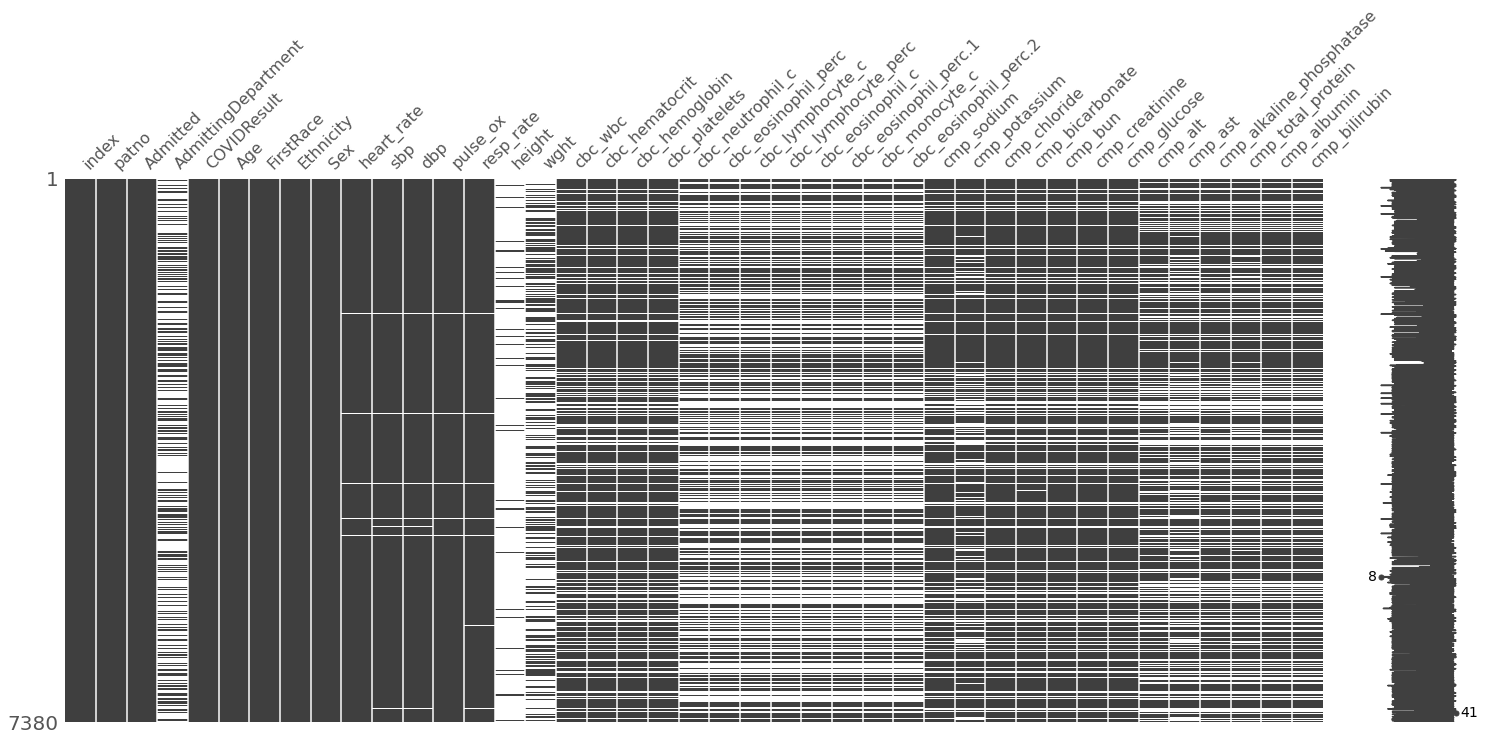

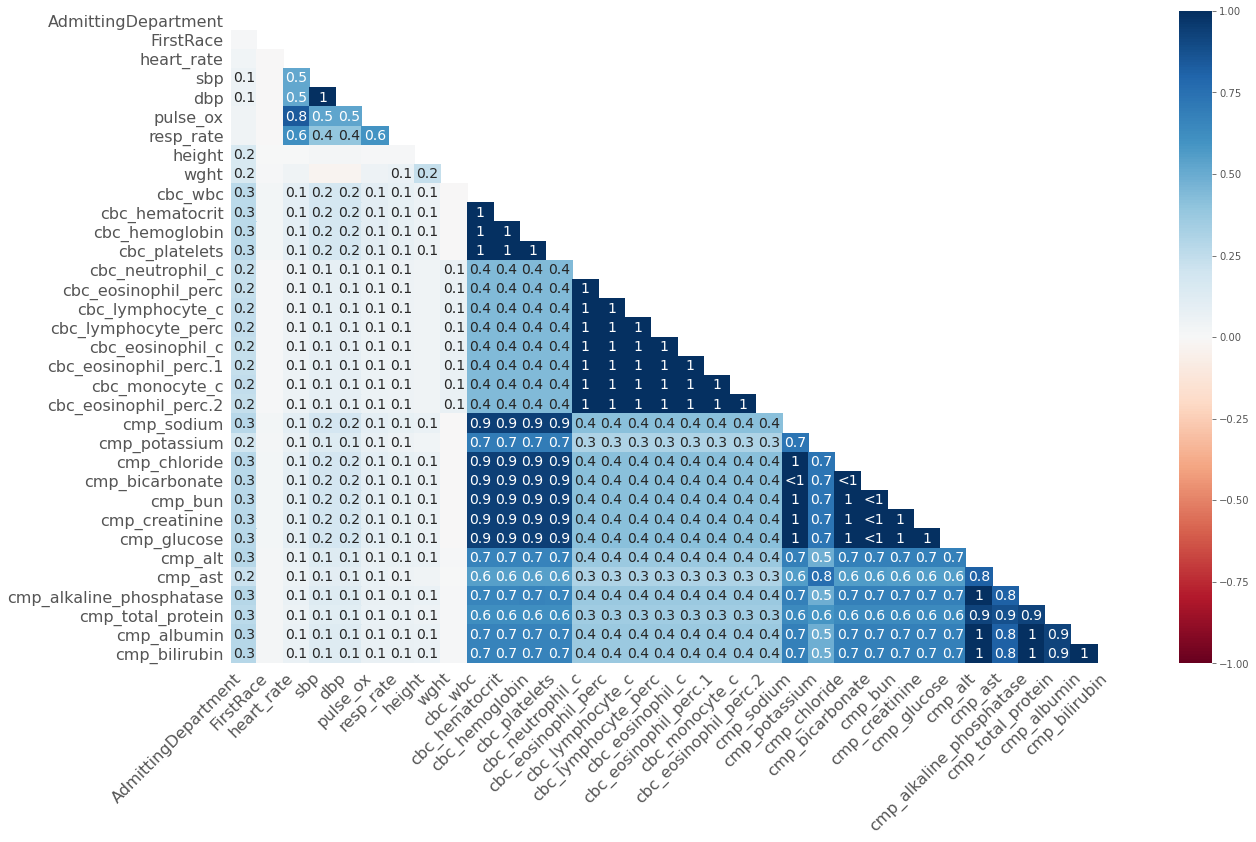

In [17]:
if show_data:
    msno.matrix(df)
    msno.heatmap(df)

## 2. Data Preparation <a class="anchor" id="prep"></a>

[Table of Contents](#toc)

#### 2.1 Drop Columns <a class="anchor" id="drop"></a>

In [18]:
# NOTE: True indicates that columns with >50% NULL will be dropped
#       False indicates that no columns are dropped
drop = False

In [19]:
if drop:
    trim_df = df.drop(columns=majority_null)
    trim_df = trim_df.drop(columns=['index', 'patno'])
    trim_df.head(5)
else:
    trim_df = df

In [20]:
trim_df.isnull().sum().sum()

69411

#### 2.2 Handle Categorical Variables <a class="anchor" id="handle1"></a>

In [21]:
trim_df.select_dtypes(include=['object']).columns

Index(['AdmittingDepartment', 'COVIDResult', 'FirstRace', 'Ethnicity', 'Sex',
       'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_alt',
       'cmp_bilirubin'],
      dtype='object')

###### 2.2.1 Manual Conversion <a class="anchor" id="manual"></a>

In [22]:
# NOTE: These five columns should be numeric, but certain < symbols make them categorical
#       Considering these data points are infrequent, I decided to replace them with a random number between 
#       zero and the upper range (Ex. <5 became a rand number between 0 and 5)
num_cat_cols = [
    'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_alt', 'cmp_bilirubin'
]
less_than_list = [
    '<5', '<2', '<0.2', '<6', '<0.1'
]


def replace_cat(val, less, num):
    """
    pd.apply helper function
    
    Parameters:
    - val: each record in the categorical columns
    - less: element from the less_than_list
    - num: number parsed from an element in the less_than_list
    
    Return:
    if the value in the column categorical (i.e. an element in the less_than_list) then
    either return a uniformly random float or random int depending on the type of num
    """
    
    if val == less:
        return random.uniform(0, num) if "." in less else random.randint(0, num)
    else:
        return float(val)

    
trim_df2 = trim_df.copy()
for col, less_than in zip(num_cat_cols, less_than_list):
    upper_range = float(less_than[1:])
    trim_df2[col] = trim_df2[col].apply(lambda x: replace_cat(x, less_than, upper_range))

if show_data:
    trim_df2.head(5)

,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26.0,31.0,2.5,82.0,14.0,26.0,80.0,8.5,4.3,0.5
1,1,2,0,NaN,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,19.0,11.0,0.9,83.0,73.0,NaN,100.0,8.1,4.6,0.6
2,2,3,0,NaN,None Detected,55,African American,Non-Hispanic,Male,83.0,...,23.0,9.0,1.2,123.0,26.0,29.0,106.0,7.1,4.0,0.7
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,30.0,45.0,1.6,297.0,22.0,NaN,78.0,7.8,3.7,0.5
4,4,5,0,NaN,None Detected,67,African American,Non-Hispanic,Female,90.0,...,27.0,25.0,1.0,96.0,12.0,18.0,122.0,7.4,3.5,0.2


In [23]:
if show_data:
    trim_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     7380 non-null   int64  
 1   patno                     7380 non-null   int64  
 2   Admitted                  7380 non-null   int64  
 3   AdmittingDepartment       3003 non-null   object 
 4   COVIDResult               7380 non-null   object 
 5   Age                       7380 non-null   int64  
 6   FirstRace                 7379 non-null   object 
 7   Ethnicity                 7380 non-null   object 
 8   Sex                       7380 non-null   object 
 9   heart_rate                7352 non-null   float64
 10  sbp                       7292 non-null   float64
 11  dbp                       7292 non-null   float64
 12  pulse_ox                  7346 non-null   float64
 13  resp_rate                 7312 non-null   float64
 14  height  

###### 2.2.2 Encoding <a class="anchor" id="encoding"></a>

In [24]:
# NOTE: Convert all remaining categorical variables using Ordinal Encoding
cat_cols = list(trim_df2.select_dtypes(include=['object']).columns)

trim_df3 = trim_df2.copy()
trim_df3['FirstRace'] = trim_df3['FirstRace'].fillna("Unspecified")
if not drop:
    trim_df3['AdmittingDepartment'] = trim_df3['AdmittingDepartment'].fillna('N/A')
for col in cat_cols:
    enc = OrdinalEncoder()
    y = enc.fit_transform(trim_df3[[col]])
    if col == 'COVIDResult':
        y = 1 - y           # Switching code (standard for the 'normal' code to be 0)
    trim_df3[col + "_Encoded"] = y
if show_data:
    trim_df3.head(5)

,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,AdmittingDepartment_Encoded,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26.0,80.0,8.5,4.3,0.5,30.0,0.0,9.0,2.0,0.0
1,1,2,0,N/A,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,NaN,100.0,8.1,4.6,0.6,1.0,0.0,9.0,2.0,0.0
2,2,3,0,N/A,None Detected,55,African American,Non-Hispanic,Male,83.0,...,29.0,106.0,7.1,4.0,0.7,1.0,0.0,0.0,2.0,1.0
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,NaN,78.0,7.8,3.7,0.5,30.0,0.0,9.0,2.0,1.0
4,4,5,0,N/A,None Detected,67,African American,Non-Hispanic,Female,90.0,...,18.0,122.0,7.4,3.5,0.2,1.0,0.0,0.0,2.0,0.0


###### 2.2.3 Categorical Codes <a class="anchor" id="codes"></a>

In [25]:
for col in cat_cols:
    if col == 'AdmittingDepartment':
        continue
    display(Markdown("**{}**".format(col)))
    for each in trim_df3.groupby([col, col + '_Encoded']).indices:
        print(each)
    print()

**COVIDResult**

('Detected', 1.0)
('None Detected', 0.0)



**FirstRace**

('African American', 0.0)
('American Indian and Alaska Native', 1.0)
('Asian', 2.0)
('Hispanic', 3.0)
('Native Hawaiian and Other Pacific Islander', 4.0)
('Other', 5.0)
('Patient Refused', 6.0)
('Patient Unavailable', 7.0)
('Unspecified', 8.0)
('White or Caucasian', 9.0)



**Ethnicity**

('*Unspecified', 0.0)
('Hispanic', 1.0)
('Non-Hispanic', 2.0)
('Patient Refused', 3.0)
('Patient Unavailable', 4.0)



**Sex**

('Female', 0.0)
('Male', 1.0)
('Unknown', 2.0)



In [26]:
trim_df3 = trim_df3.drop(columns=cat_cols)
if show_data:
    trim_df3.head(5)

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,AdmittingDepartment_Encoded,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,0,1,1,78,94.0,138.0,82.0,96.0,29.0,NaN,...,26.0,80.0,8.5,4.3,0.5,30.0,0.0,9.0,2.0,0.0
1,1,2,0,23,121.0,134.0,88.0,98.0,18.0,NaN,...,NaN,100.0,8.1,4.6,0.6,1.0,0.0,9.0,2.0,0.0
2,2,3,0,55,83.0,152.0,76.0,98.0,21.0,NaN,...,29.0,106.0,7.1,4.0,0.7,1.0,0.0,0.0,2.0,1.0
3,3,4,1,50,88.0,138.0,65.0,87.0,18.0,NaN,...,NaN,78.0,7.8,3.7,0.5,30.0,0.0,9.0,2.0,1.0
4,4,5,0,67,90.0,128.0,69.0,98.0,18.0,NaN,...,18.0,122.0,7.4,3.5,0.2,1.0,0.0,0.0,2.0,0.0


In [27]:
trim_df3.shape

(7380, 41)

In [28]:
if show_data:
    trim_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        7380 non-null   int64  
 1   patno                        7380 non-null   int64  
 2   Admitted                     7380 non-null   int64  
 3   Age                          7380 non-null   int64  
 4   heart_rate                   7352 non-null   float64
 5   sbp                          7292 non-null   float64
 6   dbp                          7292 non-null   float64
 7   pulse_ox                     7346 non-null   float64
 8   resp_rate                    7312 non-null   float64
 9   height                       456 non-null    float64
 10  wght                         3248 non-null   float64
 11  cbc_wbc                      6256 non-null   float64
 12  cbc_hematocrit               6256 non-null   float64
 13  cbc_hemoglobin    

#### 2.3 Handle Missing Values <a class="anchor" id="handle2"></a>

In [29]:
# NOTE: A indicates that remaining NULLs will be replaced with 0
#       B/Other indicates that remaining NULLs will be replaced with the column's mean value
#       Option A will be the default to avoid changing the dataset too much
fill_option = 'A'

In [30]:
num_cols = list(trim_df2.select_dtypes(include=['float64']).columns)

trim_df4 = trim_df3.copy()
for col in num_cols:
    if fill_option == 'A':
        trim_df4[col] = trim_df4[col].fillna(0)
    else:
        trim_df4[col] = trim_df4[col].replace(np.NaN, trim_df4[col].mean())
    
if show_data:
    trim_df4.head(5)

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,AdmittingDepartment_Encoded,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,0,1,1,78,94.0,138.0,82.0,96.0,29.0,0.0,...,26.0,80.0,8.5,4.3,0.5,30.0,0.0,9.0,2.0,0.0
1,1,2,0,23,121.0,134.0,88.0,98.0,18.0,0.0,...,0.0,100.0,8.1,4.6,0.6,1.0,0.0,9.0,2.0,0.0
2,2,3,0,55,83.0,152.0,76.0,98.0,21.0,0.0,...,29.0,106.0,7.1,4.0,0.7,1.0,0.0,0.0,2.0,1.0
3,3,4,1,50,88.0,138.0,65.0,87.0,18.0,0.0,...,0.0,78.0,7.8,3.7,0.5,30.0,0.0,9.0,2.0,1.0
4,4,5,0,67,90.0,128.0,69.0,98.0,18.0,0.0,...,18.0,122.0,7.4,3.5,0.2,1.0,0.0,0.0,2.0,0.0


In [31]:
trim_df3.isnull().sum().sum()

65033

In [32]:
trim_df4.isnull().sum().sum()

0

#### 2.4 Feature Scaling <a class="anchor" id="scaling"></a>

In [33]:
code_cols = [
    'Admitted', 'FirstRace_Encoded', 'Ethnicity_Encoded', 'Sex_Encoded',
    'AdmittingDepartment_Encoded', 'COVIDResult_Encoded'
]

# NOTE: This column would not exist if drop is True
if drop:
    code_cols.remove('AdmittingDepartment_Encoded')

codes_df = trim_df4[code_cols]
trim_df5 = trim_df4.drop(columns=code_cols)

scaler = StandardScaler()
scaled = scaler.fit_transform(trim_df5)
scaled_df = pd.DataFrame(data=scaled, columns=trim_df5.columns)

In [34]:
merged_df = pd.concat([scaled_df, codes_df], axis=1)
if show_data:
    merged_df.head(5)

,index,patno,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,AdmittingDepartment_Encoded,COVIDResult_Encoded
0,-1.731816,-1.731816,1.233730,-0.007125,0.117440,0.397106,-0.081200,1.162329,-0.254819,-0.760847,...,-0.038140,1.020349,0.837005,-0.077871,1,9.0,2.0,0.0,30.0,0.0
1,-1.731347,-1.731347,-1.104301,1.116931,-0.012210,0.743825,0.181805,-0.403647,-0.254819,-0.760847,...,0.179028,0.901837,1.006128,-0.012044,0,9.0,2.0,0.0,1.0,0.0
2,-1.730877,-1.730877,0.256008,-0.465074,0.571215,0.050387,0.181805,0.023438,-0.254819,1.151812,...,0.244178,0.605558,0.667883,0.053783,0,0.0,2.0,1.0,1.0,0.0
3,-1.730408,-1.730408,0.043460,-0.256915,0.117440,-0.585264,-1.264722,-0.403647,-0.254819,-0.760847,...,-0.059856,0.812953,0.498760,-0.077871,1,9.0,2.0,1.0,30.0,0.0
4,-1.729939,-1.729939,0.766124,-0.173652,-0.206684,-0.354118,0.181805,-0.403647,-0.254819,-0.760847,...,0.417912,0.694442,0.386011,-0.275353,0,0.0,2.0,0.0,1.0,0.0


#### 2.5 Train / Test Split <a class="anchor" id="split"></a>

In [35]:
train, test = train_test_split(merged_df, test_size=0.2, random_state=SEED)

#### 2.6 Final Prepared Data <a class="anchor" id="final_data"></a>

In [36]:
final_data = merged_df.copy()
final_train = train.copy()
final_test = test.copy()
target = 'COVIDResult_Encoded'

In [37]:
final_data.shape

(7380, 41)

In [38]:
final_train.shape

(5904, 41)

In [39]:
final_test.shape

(1476, 41)

In [40]:
print(final_train[target].value_counts())
print(final_test[target].value_counts())

0.0    5526
1.0     378
Name: COVIDResult_Encoded, dtype: int64
0.0    1384
1.0      92
Name: COVIDResult_Encoded, dtype: int64


## 3. Feature Selection <a class="anchor" id="feature"></a>

[Table of Contents](#toc)

In [41]:
X = final_data.loc[:, final_data.columns != target]
pos_X = trim_df4.loc[:, trim_df4.columns != target]
X_norm = MinMaxScaler().fit_transform(pos_X)
Y = final_data[target]

###### Number of Features

In [42]:
# NOTE: Set to be the length of columns to avoid removing features until the final model training
top_n_feats = len(X.columns)
# top_n_feats = 10

In [43]:
def plot_scores(scores, selector):
    """
    Simple feature score plot
    
    Parameters:
    - scores: list/collection of feature scores
    - selector: name of feature selector
    """
    plt.bar(range(len(scores)), scores, color='b')
    plt.show()

#### 3.1 Pearson Correlation <a class="anchor" id="corr"></a>

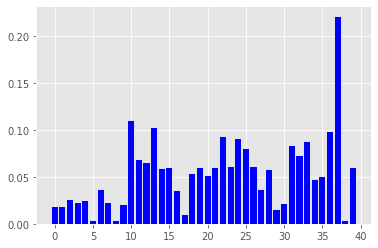

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [44]:
def correlation_selector(x, y):
    """
    Correlation Feature Selector
    
    Parameters:
    - x: input columns
    - y: output/target column
    
    Return: True/False list recording which features are in top n
    """
    correl_dict = {
        col: np.corrcoef(x[col], y)[0, 1] for col in x.columns.tolist()
    }
    correl_dict = {
        col: 0 if np.isnan(cor) else np.abs(cor) for col, cor in correl_dict.items()
    }
    plot_scores(list(correl_dict.values()), 'correlation')
    
    correl_dict = dict(sorted(correl_dict.items(), key=lambda item: item[1], reverse=True)[:top_n_feats])
    top_n = np.array([
        True if col in list(correl_dict.keys()) else False for col in x.columns.tolist()
    ])
    return top_n


corr_top_n = correlation_selector(X, Y)
corr_top_n

#### 3.2 Chi-Squared <a class="anchor" id="chi_sq"></a>

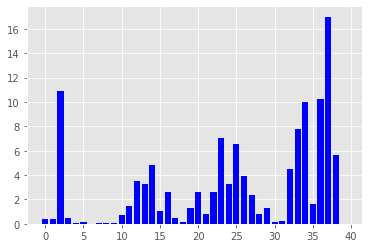

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [45]:
def chi_selector(y):
    """
    Chi-Squared Feature Selector
    
    Parameters:
    - y: output/target column
    
    Return: True/False list recording which features are in top n
    """
    chi_sq = SelectKBest(chi2, k=top_n_feats)
    chi_sq.fit(X_norm, y)
    top_n = chi_sq.get_support()
    plot_scores(chi_sq.scores_, 'chi-squared')
    return top_n


chi_top_n = chi_selector(Y)
chi_top_n

#### 3.3 Recursive Feature Elimination <a class="anchor" id="rfe"></a>

In [46]:
def rfe_selector(y):
    """
    Recursive Feature Elimination Feature Selector
    
    Parameters:
    - y: output/target column
    
    Return: True/False list recording which features are in top n
    """
    rfe = RFE(
        estimator=LogisticRegression(solver='lbfgs'), n_features_to_select=top_n_feats, step=10, verbose=0
    )
    rfe.fit(X_norm, y)
    top_n = rfe.get_support()
    return top_n


rfe_top_n = rfe_selector(Y)
rfe_top_n

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

#### 3.4 Lasso: SelectFromModel <a class="anchor" id="lasso"></a>

In [47]:
def lasso_selector(y):
    """
    Lasso Feature Selector (Logistic Regression)
    
    Parameters:
    - y: output/target column
    
    Return: True/False list recording which features are in top n
    """
    lasso = SelectFromModel(
        LogisticRegression(solver='lbfgs', penalty="l2"), max_features=top_n_feats
    )
    lasso.fit(X_norm, y)
    top_n = lasso.get_support()
    return top_n


lasso_top_n = lasso_selector(Y)
lasso_top_n

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True,  True, False,  True,  True,
        True, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False,  True,  True,
       False,  True,  True, False])

#### 3.5 RandomForestClassifier: SelectFromModel <a class="anchor" id="rfc"></a>

In [48]:
def rfc_selector(x, y):
    """
    Random Forest Classifier Feature Selector
    
    Parameters:
    - x: input columns
    - y: output/target column
    
    Return: True/False list recording which features are in top n
    """
    rfc = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=top_n_feats)
    rfc.fit(x, y)
    top_n = rfc.get_support()
    return top_n


rfc_top_n = rfc_selector(X, Y)
rfc_top_n

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True])

#### 3.6 Cumulative Feature Selection <a class="anchor" id="cum"></a>

In [49]:
cumm_df = pd.DataFrame({
    'feature': X.columns.tolist(),
    'correlation': corr_top_n,
    'chi-sq': chi_top_n,
    'rfe': rfe_top_n,
    'lasso': lasso_top_n,
    'rfc': rfc_top_n
})
cumm_df['total'] = np.sum(cumm_df, axis=1)
cumm_df = cumm_df.sort_values(['total', 'feature'], ascending=False)
cumm_df.index = range(1, len(cumm_df) + 1)
cumm_df

,feature,correlation,chi-sq,rfe,lasso,rfc,total
1,cbc_platelets,True,True,True,True,True,5
2,Ethnicity_Encoded,True,True,True,True,True,5
3,wght,True,True,True,False,True,4
4,sbp,True,True,True,False,True,4
5,resp_rate,True,True,True,False,True,4
6,pulse_ox,True,True,True,False,True,4
7,patno,True,True,True,False,True,4
8,index,True,True,True,False,True,4
9,heart_rate,True,True,True,False,True,4
10,dbp,True,True,True,False,True,4


In [50]:
top_n_features = list(cumm_df.iloc[:top_n_feats]['feature'])
top_n_features

['cbc_platelets',
 'Ethnicity_Encoded',
 'wght',
 'sbp',
 'resp_rate',
 'pulse_ox',
 'patno',
 'index',
 'heart_rate',
 'dbp',
 'cmp_total_protein',
 'cmp_sodium',
 'cmp_bilirubin',
 'cbc_wbc',
 'cbc_neutrophil_c',
 'cbc_monocyte_c',
 'cbc_lymphocyte_perc',
 'cbc_lymphocyte_c',
 'cbc_hematocrit',
 'cbc_eosinophil_c',
 'Sex_Encoded',
 'Age',
 'AdmittingDepartment_Encoded',
 'Admitted',
 'height',
 'cmp_potassium',
 'cmp_glucose',
 'cmp_creatinine',
 'cmp_chloride',
 'cmp_bun',
 'cmp_bicarbonate',
 'cmp_ast',
 'cmp_alt',
 'cmp_alkaline_phosphatase',
 'cmp_albumin',
 'cbc_hemoglobin',
 'cbc_eosinophil_perc.2',
 'cbc_eosinophil_perc.1',
 'cbc_eosinophil_perc',
 'FirstRace_Encoded']

## 4. Model Selection <a class="anchor" id="model"></a>

[Table of Contents](#toc)

#### 4.1 Train / Test Data <a class="anchor" id="tt"></a>

In [51]:
X_train = final_train[top_n_features]
y_train = final_train[target]
X_test = final_test[top_n_features]
y_test = final_test[target]

In [52]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print()
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (5904, 40)
y_train (5904,)

X_test (1476, 40)
y_test (1476,)


#### 4.2 Model Evaluation Functions <a class="anchor" id="funcs"></a>

In [53]:
def plot_metric(hist, metric):
    """
    Plot a specified metric for a fitted model
    
    Parameters:
    - hist: model's train history
    - metric: specified metric to plot
    """
    train_metrics = hist.history[metric]
    val_metrics = hist.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and Validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [54]:
def plot_history(hist):
    """
    Plot loss and accuracy for a fitted model
    
    Parameters:
    - hist: model's train history
    """
    display(Markdown('**Training/Validation Loss and Accuracy**'))
    pd.DataFrame(hist.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

In [55]:
def metric_evaluation(y_test, y_pred, labels=True):
    """
    Output four key performance metrics (accuracy, precision, recall, f1)
    
    Parameters:
    - y_test: target's test array/column
    - y_pred: model's prediction for output column
    - labels: True/False, controls verbosity
    """
    if labels:
        display(Markdown('**Metric Scores**'))
    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("Precision: {:.2f}%".format(precision_score(y_test, y_pred) * 100))
    print("Recall: {:.2f}%".format(recall_score(y_test, y_pred) * 100))
    print("F1: {:.2f}%".format(f1_score(y_test, y_pred) * 100))
    if labels:
        display(Markdown('**Confusion Matrix**'))
    print(confusion_matrix(y_test, y_pred))

In [56]:
def plot_confusion_matrix(y_test, y_pred, labels=['None Detected', 'Detected']):
    """
    Plot confusion matrix
    
    Parameters:
    - y_test: target's test array/column
    - y_pred: model's prediction for output column
    - labels: class labels for matrix
    """
    cm_df = pd.DataFrame(
        confusion_matrix(y_test, y_pred), columns=labels, index=labels
    )
    ax = sns.heatmap(
        data=cm_df, cmap=cm.Blues, annot=True, fmt='d'
    )
    ax.set(xlabel='Predicted', ylabel='Actual')
    plt.show()

In [57]:
EPOCHS = 10
BATCH_SIZE = 200
VAL_SPLIT = 0.2

In [58]:
def test_models(models, xy, isolate=None):
    """
    'Automate' compilation/fitting/predicting/evaluating of a deep learning model
    
    Parameters:
    - models: list of dictionaries* that store each model to be tested
    - xy: array of x and y train/test split data
    - isolate: optional ability to test a single model, int expected
    
    * dictionaries need specific key, value pairs, including the name of the model, the stored model itself,
    a specified loss function, optimize, whether it is binary classification, and the expected input dimension
    
    """
    
    X_train, y_train, X_test, y_test = xy
    
    for i, m in enumerate(models):
        X_train_arr = np.array(X_train.values.tolist())
        y_train_arr = np.array(y_train)
        X_test_arr = np.array(X_test.values.tolist())
        y_test_arr = np.array(y_test)
        name, model, loss, optimizer, binary, dimensions = m.values()
        
        if isolate is not None and i + 1 != isolate:
            print('Skipping Model {}...'.format(i + 1))
            continue
        
        display(Markdown('### Model {} – {}'.format(i + 1, name)))
        
        # 1. Compile
        model.compile(
            loss=loss, optimizer=optimizer, metrics=['accuracy']
        )
        
        # 2. Fit
        shape = X_train_arr.shape
        if dimensions == 3:
            X_train_arr = X_train_arr.reshape(shape[0], shape[1], 1)
        elif dimensions == 4:
            X_train_arr = X_train_arr.reshape(shape[0], shape[1], 1, 1)
        
        history = model.fit(
            X_train_arr, y_train_arr,
            batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VAL_SPLIT, shuffle=True, verbose=0
        )
        
        # 3. Visualize Model
        display(Markdown("**Summary**"))
        model.summary()
        plot_history(history)
        
        # 4. Evaluate
        shape = X_test_arr.shape
        if dimensions == 3:
            X_test_arr = X_test_arr.reshape(shape[0], shape[1], 1)
        elif dimensions == 4:
            X_test_arr = X_test_arr.reshape(shape[0], shape[1], 1, 1)
            
        display(Markdown("**Evaluation and Prediction**"))
        loss, accuracy = model.evaluate(x=X_test_arr, y=y_test_arr)
        print("\nLoss: {:.2f}%".format(loss * 100))
        print("Accuracy: {:.2f}%".format(accuracy * 100))

        # 5. Predict
        y_prediction_array = model.predict(X_test_arr)
        
        if not binary:
            y_prediction = np.argmax(y_prediction_array, axis=1)
        else:
            y_prediction = np.round(y_prediction_array)
        
        # 6. Visualize Predictions
        metric_evaluation(y_test_arr, y_prediction)
        plot_confusion_matrix(y_test_arr, y_prediction)
        
        print()

#### 4.3 Model Construction <a class="anchor" id="models"></a>

In [59]:
tf.keras.backend.set_floatx('float64')
tf.set_random_seed(SEED)
np.random.seed(SEED)

###### 4.3.1 Decision Trees <a class="anchor" id="dt"></a>

**Metric Scores**

Accuracy: 94.11%
Precision: 100.00%
Recall: 5.43%
F1: 10.31%


**Confusion Matrix**

[[1384    0]
 [  87    5]]


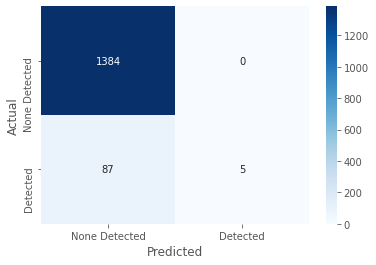

In [60]:
dt = DecisionTreeClassifier(
    max_depth=4, criterion="entropy", random_state=SEED
)
dt = dt.fit(X_train, y_train)
y_prediction = dt.predict(X_test)
metric_evaluation(y_test, y_prediction)
plot_confusion_matrix(y_test, y_prediction)

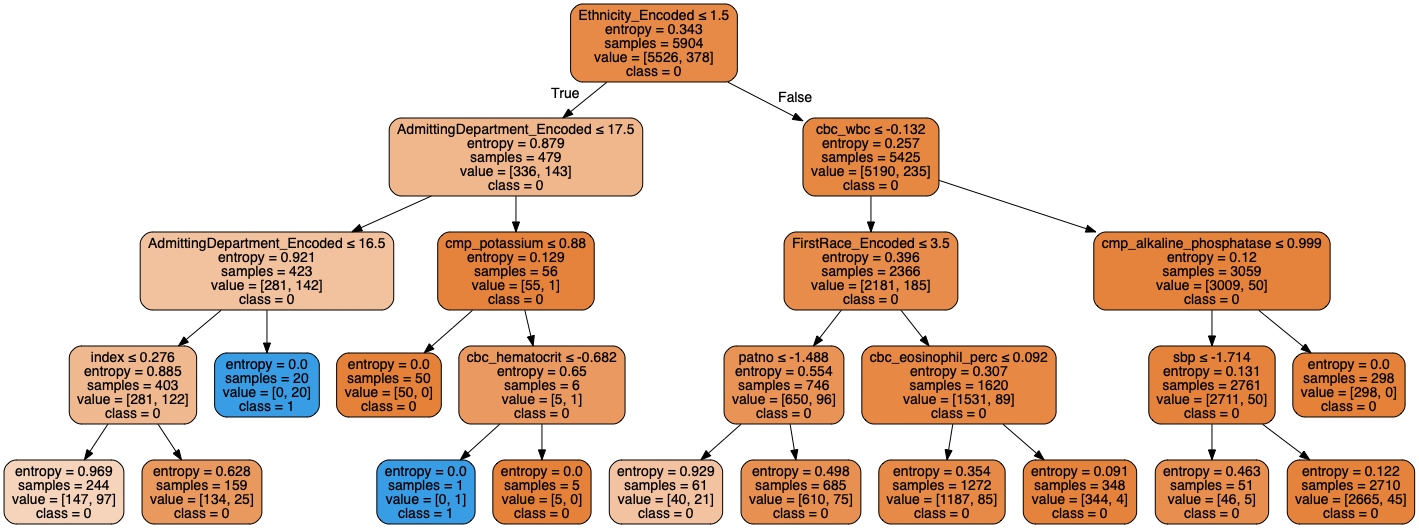

In [61]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=top_n_features, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('rfc.png')
Image(graph.create_png())

###### 4.3.2 Random Forest Classifier <a class="anchor" id="rfc2"></a>

**Metric Scores**

Accuracy: 94.04%
Precision: 83.33%
Recall: 5.43%
F1: 10.20%


**Confusion Matrix**

[[1383    1]
 [  87    5]]


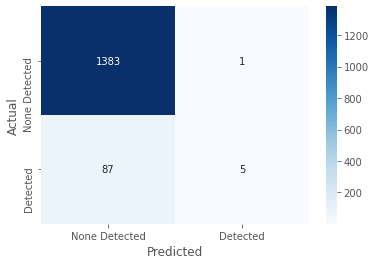

In [62]:
rfc = RandomForestClassifier(
    n_estimators=100, bootstrap=True, max_features='sqrt', random_state=SEED
)
rfc.fit(X_train, y_train)
y_prediction = rfc.predict(X_test)
metric_evaluation(y_test, y_prediction)
plot_confusion_matrix(y_test, y_prediction)

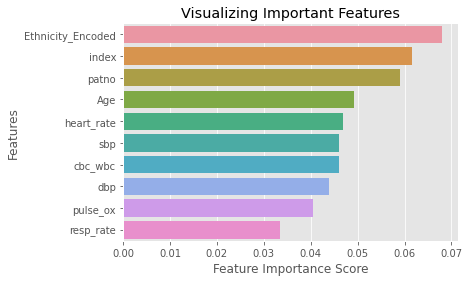

In [63]:
feature_importance = pd.Series(rfc.feature_importances_,index=top_n_features).sort_values(ascending=False).iloc[:10]
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

###### 4.3.3 K-Nearest Neighbors Classifier <a class="anchor" id="knn"></a>

**Metric Scores**

Accuracy: 93.43%
Precision: 42.86%
Recall: 16.30%
F1: 23.62%


**Confusion Matrix**

[[1364   20]
 [  77   15]]


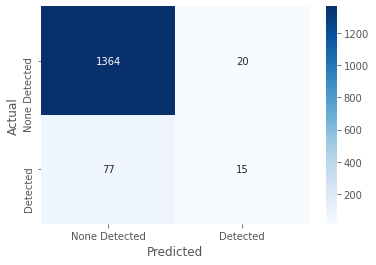

In [64]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_prediction = knn.predict(X_test)
metric_evaluation(y_test, y_prediction)
plot_confusion_matrix(y_test, y_prediction)

###### 4.3.4 Simple Deep Neural Network <a class="anchor" id="dnn"></a>

In [65]:
dnn = Sequential([
    Dense(top_n_feats//2, activation='relu', input_shape=(top_n_feats,)),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(2, activation='softmax')
])

###### 4.3.5 Convolutional Neural Network <a class="anchor" id="cnn"></a>

In [66]:
cnn = Sequential([
    Conv2D(32, kernel_size=(3, 3), input_shape=(top_n_feats, 1, 1), activation='linear', padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='linear',padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='linear',padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Flatten(),
    Dense(128, activation='linear'),
    LeakyReLU(alpha=0.1),
    Dense(2, activation='softmax')
])

###### 4.3.6 Recurrent Neural Network <a class="anchor" id="rnn"></a>

In [67]:
# rnn = Sequential([
#     SimpleRNN(16, return_sequences=True, input_shape=(top_n_feats, 1)),
#     SimpleRNN(8, return_sequences=True),
#     Dense(2, activation='softmax')
# ])

# NOTE: More temporal; leaving in...
rnn = Sequential([
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(2, activation='softmax')
])

#### 4.4 Simultaneous Model Evaluation <a class="anchor" id="eval"></a>

### Model 1 – Deep Neural Network

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


**Summary**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
Total params: 1,178
Trainable params: 1,178
Non-trainable params: 0
______________________________________________________

**Training/Validation Loss and Accuracy**

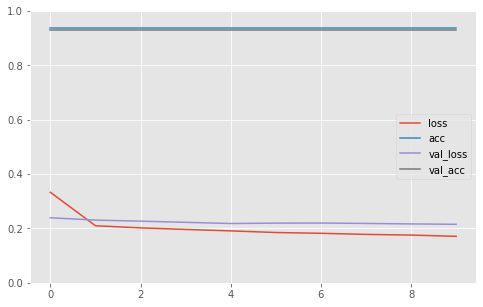

**Evaluation and Prediction**


Loss: 18.94%
Accuracy: 93.77%


**Metric Scores**

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


**Confusion Matrix**

[[1384    0]
 [  92    0]]


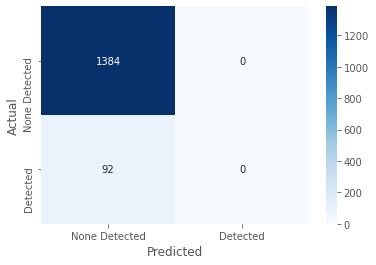

### Model 2 – Convolutional Neural Network

**Summary**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 1, 32)         320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 40, 1, 32)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 1, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 1, 64)         18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20, 1, 64)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 1, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 1, 128)       

**Training/Validation Loss and Accuracy**

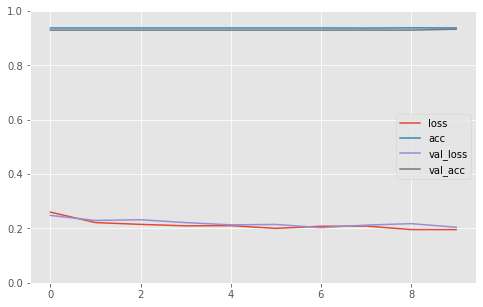

**Evaluation and Prediction**


Loss: 19.50%
Accuracy: 93.77%


**Metric Scores**

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


**Confusion Matrix**

[[1384    0]
 [  92    0]]


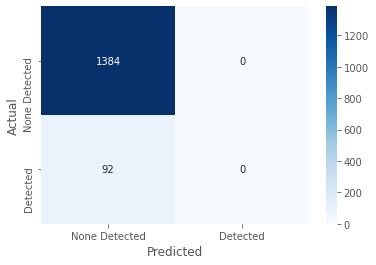

### Model 3 – Recurrent Neural Network

**Summary**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  16896     
_________________________________________________________________
dense_8 (Dense)              multiple                  130       
Total params: 17,026
Trainable params: 17,026
Non-trainable params: 0
_________________________________________________________________


**Training/Validation Loss and Accuracy**

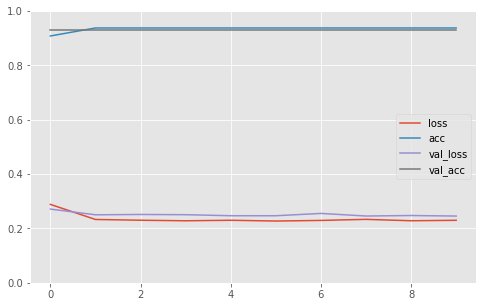

**Evaluation and Prediction**


Loss: 22.14%
Accuracy: 93.77%


**Metric Scores**

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


**Confusion Matrix**

[[1384    0]
 [  92    0]]


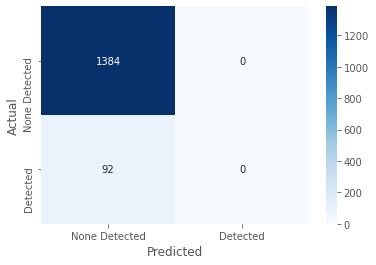


CPU times: user 2min 13s, sys: 33.1 s, total: 2min 46s
Wall time: 1min 2s


In [68]:
%%time
test_models([
    {'name': 'Deep Neural Network', 'model': dnn,
     'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-2),
     'binary': False, 'dims': 2},
    {'name': 'Convolutional Neural Network', 'model': cnn,
     'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-2),
     'binary': False, 'dims': 4},
    {'name': 'Recurrent Neural Network', 'model': rnn,
     'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-2),
     'binary': False, 'dims': 3}
], (X_train, y_train, X_test, y_test))

#### 4.5 Randomized Search <a class="anchor" id="search"></a>

In [69]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[top_n_feats]):
    '''
    Keras Regressor function wrapper, version 1
    
    Parameters:
    - n_hidden: number of hidden layers
    - n_neurons: number of nuerons per layer
    - learning_rate: optimizer learning rate
    - input_shape: shape of the input layer
    
    Return: compiled custom model
    '''
    model = Sequential([
        InputLayer(input_shape=input_shape)
    ])
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(1))
    optimizer = SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [70]:
def build_model2(n_hidden, n_neurons):
    '''
    Keras Regressor function wrapper, version 2
    
    Parameters:
    - n_hidden: number of hidden layers
    - n_neurons: number of nuerons per layer
    
    Return: compiled custom model
    '''
    model = Sequential([
        InputLayer(input_shape=[top_n_feats])
    ])
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(1))
    return model

In [71]:
def rnd_search_results(rscv):
    '''
    Print out results of cross-validated randomized search, including best parameters, top n models, etc.
    
    Parameters
    - rscv: Randomized Search CV post-fit model
    '''
    global final_top_x_models
    
    # 1. Best Model Params
    display(Markdown("**Best Parameters**"))
    best_params = rscv.best_params_
    for k, v in best_params:
        print(k + ":", v)
    print("Best Score: {}".format(rscv.best_score_))
    
    # 2. CV Results
    cv_results = pd.DataFrame(rnd_search_cv.cv_results_)
    print(cv_results)
    
    # 3. Top X
    top_x = 3
    top_x_models = cv_results.loc[cv_results['rank_test_score'].isin(range(1, top_x+1))].sort_values(
        by=['rank_test_score']
    )
    final_top_x_models = top_x_models.reset_index()
    print(final_top_x_models)
    
    # 4. Best!
    print(cv_results.iloc[rnd_search_cv.best_index_])

In [72]:
# NOTE: True indicates that the RandomizedSearch should run
#       False indicates that it should not
#       Set to False to avoid ~25 min run time...
run = False

In [73]:
%%time

hyperparameters = {
    'n_hidden': [0, 1, 2, 3],
    'n_neurons': np.arange(1, 100),
    'learning_rate': reciprocal(3e-4, 3e-2)
}

if run:
    keras_reg = KerasRegressor(build_model)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)
    rnd_search_cv = RandomizedSearchCV(keras_reg, hyperparameters, n_iter=10, cv=cv)
    
    rnd_search_cv.fit(
        X_train, y_train, epochs=EPOCHS, validation_split=VAL_SPLIT,
        callbacks=[EarlyStopping(patience=10)], verbose=0
    )
    
    rnd_search_results(rnd_search_cv)
    
    best_models_list = [{
        'name': 'Randomized Search: #{} Model'.format(idx + 1),
        'model': build_model2(n_hidden=model['param_n_hidden'], n_neurons=model['param_n_neurons']),
        'loss': 'sparse_categorical_crossentropy',
        'optimizer': SGD(learning_rate=model['param_learning_rate'])
    } for idx, model in final_top_x_models.iterrows()]
    
    test_models(best_models_list, (X_train, y_train, X_test, y_test))

CPU times: user 1.15 ms, sys: 94 µs, total: 1.24 ms
Wall time: 1.25 ms


## 5. Generative Adverserial Networks (GAN) <a class="anchor" id="gan"></a>

[Table of Contents](#toc)

#### 5.1 Network Setup <a class="anchor" id="setup2"></a>

In [74]:
RAND_DIM = 32
NB_STEPS = 500 + 1
BASE_N_COUNT = 128
BATCH_SIZE = 128
NUM_UPDATES_D = 1         # number of critic network updates per adversarial training step
NUM_UPDATES_G = 1         # number of generator network updates per adversarial training step
NUM_PRE_TRAIN_STEPS = 100 # number of steps to pre-train the critic before starting adversarial training
LOG_INTERVAL = 100        # interval (in steps) at which to log loss summaries and save plots of image samples to disc
LEARNING_RATE = 5e-4 
DIRECTORY = 'GAN/outputs/'
SHOW = True
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

arguments = [
    RAND_DIM, NB_STEPS, BATCH_SIZE, NUM_UPDATES_D, NUM_UPDATES_G, NUM_PRE_TRAIN_STEPS, LOG_INTERVAL,
    LEARNING_RATE, BASE_N_COUNT, DIRECTORY, generator_model_path, discriminator_model_path, loss_pickle_path, SHOW
]

In [75]:
# NOTE: True indicates that the training data will include all real samples
#       False indicates that the training data will include only detected cases
#       Set to False to generate only new detected cases
all_data = False

In [76]:
target = 'COVIDResult_Encoded'
if all_data:
    train = final_data.copy()
else:
    all_detected = final_data.loc[final_data[target] == 1]
    train = all_detected.copy().reset_index(drop=True)

In [77]:
all_columns = list(train.columns.tolist())
data_cols = all_columns[:-1]
label_cols = [target]
train_no_label = train[data_cols] / 10

In [78]:
if show_data:
    train.head(5)

,index,patno,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,AdmittingDepartment_Encoded,COVIDResult_Encoded
0,-1.728061,-1.728061,0.383537,0.742246,1.413939,0.801611,0.313307,-0.118924,-0.254819,0.928464,...,-0.385608,0.516674,0.724257,-0.209526,0,2.0,1.0,0.0,1.0,1.0
1,-1.723367,-1.723367,0.511066,-0.007125,1.997363,0.974970,-0.607210,0.592883,-0.254819,-0.760847,...,0.037869,0.901837,0.667883,-0.077871,1,9.0,2.0,0.0,30.0,1.0
2,-1.719143,-1.719143,1.488788,-0.215283,-0.303922,0.686038,-0.344205,0.165799,-0.254819,-0.760847,...,-0.287882,0.605558,0.498760,-0.077871,1,9.0,2.0,0.0,30.0,1.0
3,-1.714449,-1.714449,-1.104301,1.241826,-0.401159,-0.007399,-0.475707,2.728304,-0.254819,-0.760847,...,-0.331316,-1.498025,0.329637,-0.143698,1,9.0,2.0,1.0,30.0,1.0
4,-1.698959,-1.698959,0.893653,-0.798127,-1.405946,-1.220915,-1.133219,0.450522,3.495933,1.138256,...,-0.450758,0.546302,0.386011,-0.209526,1,0.0,2.0,0.0,30.0,1.0


#### 5.2 Train GAN Models <a class="anchor" id="train"></a>

In [79]:
# NOTE: 'gan' vs 'cgan' - decides which GAN 'flavour' to use
gan_model = 'cgan'

###### 5.2.1 GAN <a class="anchor" id="gan2"></a>

In [80]:
%%time
# GAN
if gan_model == 'gan':
    GAN.adversarial_training_GAN(
        arguments=arguments, train=train_no_label, data_cols=data_cols, seed=SEED
    )

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 9.06 µs


###### 5.2.2 CGAN <a class="anchor" id="cgan"></a>

data_dim:  40
data_cols:  ['index', 'patno', 'Age', 'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit', 'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c', 'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc', 'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c', 'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride', 'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose', 'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein', 'cmp_albumin', 'cmp_bilirubin', 'Admitted', 'FirstRace_Encoded', 'Ethnicity_Encoded', 'Sex_Encoded', 'AdmittingDepartment_Encoded']
label_dim:  1
label_cols:  ['COVIDResult_Encoded']
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Model: "generator"
__________________________________________________________________________________________________
Layer (type)           

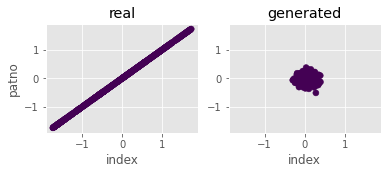

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 5.7984, 0.0218, 0.1009, 1.0000
D Real - D Gen: 0.0790


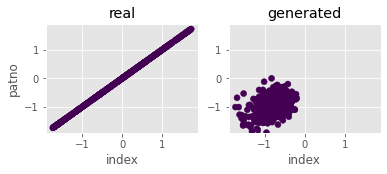

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 5.0100, 0.0764, 0.1926, 1.0000
D Real - D Gen: 0.1162


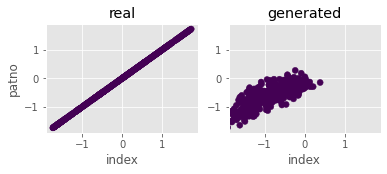

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 3.2496, 0.1917, 0.4529, 0.9872
D Real - D Gen: 0.2612


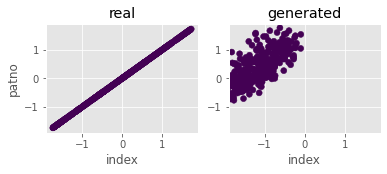

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 3.2068, 0.2540, 0.4041, 1.0000
D Real - D Gen: 0.1501


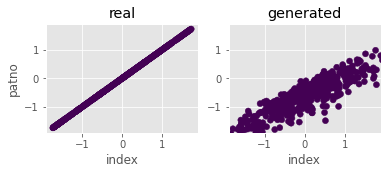

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 2.4432, 0.3367, 0.6532, 1.0000
D Real - D Gen: 0.3166


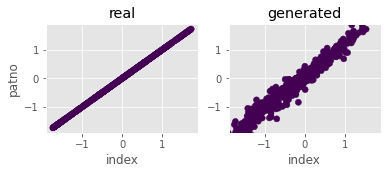

CPU times: user 1min 8s, sys: 3.85 s, total: 1min 12s
Wall time: 29.3 s


In [81]:
%%time
# CGAN
if gan_model == 'cgan':
    GAN.adversarial_training_GAN(
        arguments=arguments, train=train, data_cols=data_cols, label_cols=label_cols, seed=SEED
    )

###### 5.2.3 WGAN and WCGAN <a class="anchor" id="wgan"></a>

In [82]:
# %%time
# # WGAN
# GAN.adversarial_training_WGAN(
#     arguments=arguments, train=train_no_label, data_cols=data_cols, seed=SEED
# )
# # WCGAN
# GAN.adversarial_training_WGAN(
#     arguments=arguments, train=train, data_cols=data_cols, label_cols=label_cols, seed=SEED
# )

#### 5.3 Loss Information <a class="anchor" id="loss"></a>

CPU times: user 315 ms, sys: 9.44 ms, total: 324 ms
Wall time: 354 ms


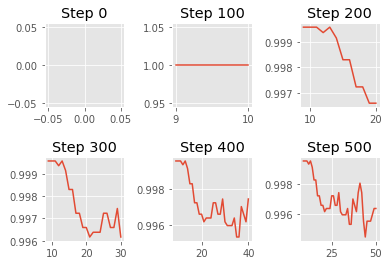

In [83]:
%%time
TYPE_ = 'CGAN'

fig = plt.figure()
fig.subplots_adjust(hspace=0.6, wspace=0.6)
for i, step in zip(range(1, 7), range(0, 600, 100)):
    [combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(
        open('{}{}_losses_step_{}.pkl'.format(DIRECTORY, TYPE_, step), 'rb')
    )
    
    ax = fig.add_subplot(2, 3, i)
    ax.plot(pd.DataFrame(xgb_losses).rolling(10).mean())
    ax.title.set_text('Step {}'.format(step))

#### 5.4 Generate New Data <a class="anchor" id="new_data"></a>

In [84]:
# NOTE: Set to balance the dataset between normal and detected cases
if all_data:
    NEW = len(train)
else:
    none, detected = final_data[target].value_counts()
    NEW = none - detected

In [85]:
np.random.seed(SEED) 
DATA_DIM = len(data_cols)
LABEL_DIM = len(label_cols)
WITH_CLASS = True if LABEL_DIM > 0 else False

In [86]:
def generate_helper(size, generator):
    '''
    GAN helper function to allow for multiple generative processes (when creating only Detected data points)
    
    Parameters:
    - size: number of data points to create
    - generator: loaded generator model
    
    Return:
    x: numpy array of batch of original dataset
    g_z: numpy array of GAN generated (generator prediction) data
    '''
    
    x = GAN.get_data_batch(train, size, seed=SEED)
    labels = x[:, -LABEL_DIM:]
    
    if all_data: 
        z = np.random.normal(size=(size, RAND_DIM))
        g_z = generator.predict([z, labels]) if WITH_CLASS else generator.predict(z)
    else:
        for _ in range(NEW//size):
            new_z = np.random.normal(size=(size, RAND_DIM))
            new_g_z = generator.predict([new_z, labels]) if WITH_CLASS else generator.predict(new_z)
            try:
                g_z = np.append(g_z, new_g_z, axis=0)
            except:
                g_z = new_g_z
    
    return np.array(x), np.array(g_z)

Accuracy: 0.9969604863221885


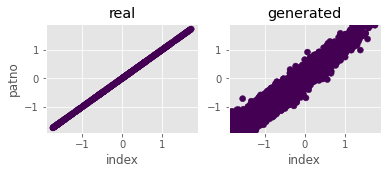

In [87]:
def generate():  
    '''
    Use Generative Adversarial Networks (GAN) to generate new data points.
    Depending on previously defined variables (NEW, all_data), the function will either:
        - generate a new set of data with an equivalent output class distribution to the original data set
        - generate roughly 6,000 Detected data points to balance the output class of post-GAN data set
    
    Return:
    x: batch of original dataset
    g_z: GAN generated (generator prediction) data
    '''
    # 1. Define Models
    generator, discriminator, combined = GAN.define_models_CGAN(
        RAND_DIM, DATA_DIM, LABEL_DIM, BASE_N_COUNT
    )
    generator.load_weights('GAN/outputs/CGAN_generator_model_weights_step_500.h5')
    
    # 2. Generate Batches of Data
    test_size = len(train)
    x, g_z = generate_helper(test_size, generator)
        
    # 3. Visualize Accuracy + New Data
    print("Accuracy:", GAN.CheckAccuracy(
        x, g_z, data_cols, label_cols, seed=SEED, with_class=WITH_CLASS, data_dim=DATA_DIM
    ))
    GAN.PlotData(
        x, g_z, data_cols, label_cols, seed=SEED, with_class=WITH_CLASS, data_dim=DATA_DIM
    )
    return x, g_z
    
batch, generated = generate()

#### 5.5 Test New Data on Models <a class="anchor" id="train_gan"></a>

In [88]:
real = pd.DataFrame(batch, columns=data_cols+label_cols)
real['syn_label'] = 0
if show_data:
    real.head(5)

,index,patno,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,AdmittingDepartment_Encoded,COVIDResult_Encoded,syn_label
0,0.394523,0.394523,0.936163,0.575719,-0.174272,-0.874197,0.181805,-0.403647,-0.254819,-0.760847,...,-1.498025,-1.587089,-0.407007,0.0,5.0,1.0,0.0,1.0,1.0,0
1,-0.019010,-0.019010,-0.041559,-0.090388,0.603627,0.108173,0.313307,-0.403647,-0.254819,-0.760847,...,-1.498025,-1.587089,-0.407007,0.0,0.0,2.0,0.0,1.0,1.0,0
2,-1.614938,-1.614938,-0.721714,-0.589969,-0.012210,-0.585264,0.313307,-0.546008,-0.254819,1.302216,...,0.872209,1.006128,-0.209526,0.0,0.0,2.0,1.0,1.0,1.0,0
3,1.124425,1.124425,-0.721714,-0.256915,-0.660459,-0.122972,0.444810,-0.118924,-0.254819,-0.760847,...,0.575930,0.498760,-0.077871,0.0,9.0,2.0,0.0,1.0,1.0,0
4,0.020888,0.020888,0.468557,0.242665,-0.271509,0.743825,-0.081200,0.450522,-0.254819,1.238310,...,0.901837,0.216888,0.382919,1.0,0.0,2.0,1.0,17.0,1.0,0


In [89]:
test = pd.DataFrame(generated, columns=data_cols+label_cols)
test['syn_label'] = 1
if show_data:
    test.head(5)

,index,patno,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,AdmittingDepartment_Encoded,COVIDResult_Encoded,syn_label
0,1.223124,1.491129,-2.737976,1.399494,-1.386544,-0.501990,1.449059,-2.095334,0.270689,-3.097788,...,2.022056,1.638847,-1.141233,0.418394,10.454322,2.525857,-0.540845,1.274569,1.0,1
1,-0.227113,-0.479936,1.782264,-0.676477,0.048583,0.329885,-0.514305,-0.790510,-0.092763,-1.142176,...,1.079330,1.185674,0.172458,0.760204,3.147822,2.111329,0.147090,1.500236,1.0,1
2,-1.147590,-1.070447,0.676109,1.185947,0.216858,0.812511,-0.359144,-1.328841,0.048898,-2.022192,...,1.836808,2.229473,-0.111814,0.929674,-1.334052,3.089162,0.089177,0.959634,1.0,1
3,-0.359664,-0.335229,-0.185380,1.284918,0.429683,1.038150,0.183322,-1.520229,-0.237510,-1.965135,...,0.785267,1.565376,-0.739223,0.463818,-2.162109,2.462553,-0.165612,0.401738,1.0,1
4,-1.799318,-1.897795,-0.190404,1.561795,-0.423960,0.800926,-0.016401,-0.739933,0.053609,-1.648328,...,1.066451,0.810435,-0.135254,0.981445,2.524375,1.580305,0.246800,1.683579,1.0,1


In [90]:
real.shape

(470, 42)

In [91]:
test.shape

(6110, 42)

In [92]:
# NOTE: Even split between real and generated data points
SPLIT = 0.5

In [93]:
n_real, n_test = int(len(real)*SPLIT), int(len(test)*SPLIT)

In [94]:
train_gan = pd.concat([real[:n_real], test[:n_test]], axis=0)
train_gan = train_gan.sample(frac=1).reset_index(drop=True) # shuffle
test_gan = pd.concat([real[n_real:], test[n_test:]], axis=0)
test_gan = test_gan.sample(frac=1).reset_index(drop=True) # shuffle

In [95]:
print('Train:', train_gan.shape)
print('Test:', test_gan.shape)

Train: (3290, 42)
Test: (3290, 42)


In [96]:
X = train_gan.columns[:-2]
y = train_gan.columns[-1]
y_true = test_gan[y]
d_train = xgb.DMatrix(train_gan[X], train_gan[y], feature_names=X)
d_test = xgb.DMatrix(test_gan[X], feature_names=X)

In [97]:
parameters = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': SEED,
    'eval_metric': 'auc'
}
xgb_clf = xgb.train(parameters, d_train, num_boost_round=10)

**Metric Scores**

Accuracy: 99.70%
Precision: 99.67%
Recall: 100.00%
F1: 99.84%


**Confusion Matrix**

[[ 235   10]
 [   0 3045]]


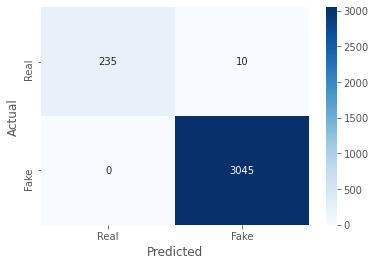

In [98]:
y_pred = xgb_clf.predict(d_test)
metric_evaluation(np.round(y_pred), y_true)
plot_confusion_matrix(np.round(y_pred), y_true, labels=['Real', 'Fake'])

#### 5.6 Plot Real vs Test Data <a class="anchor" id="plot"></a>

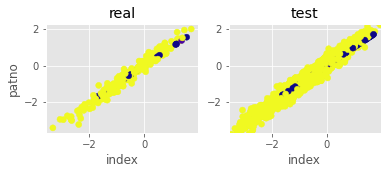

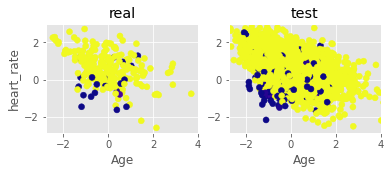

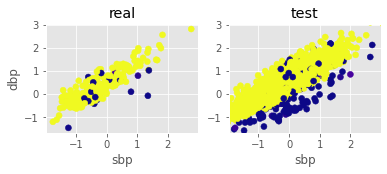

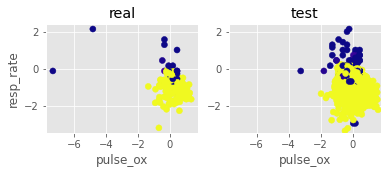

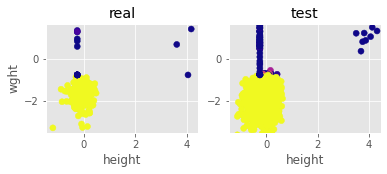

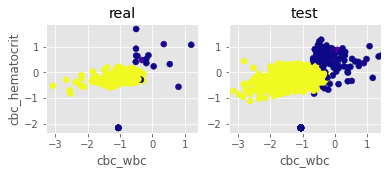

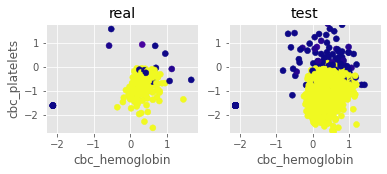

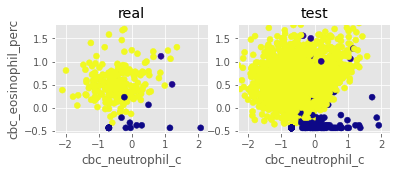

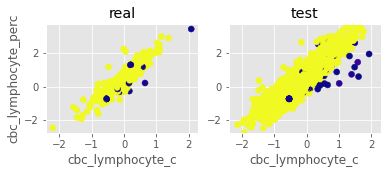

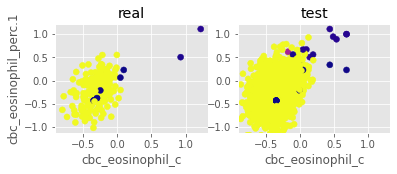

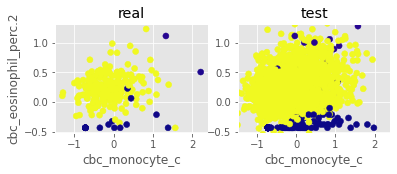

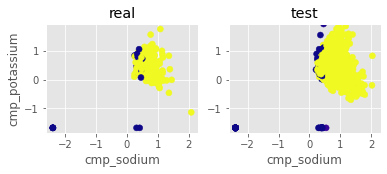

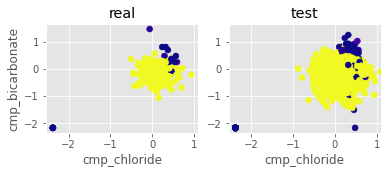

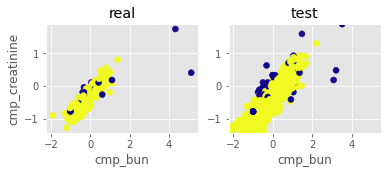

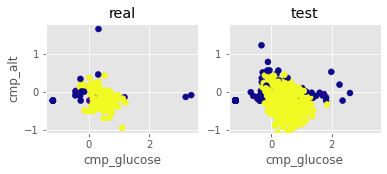

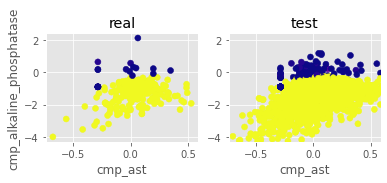

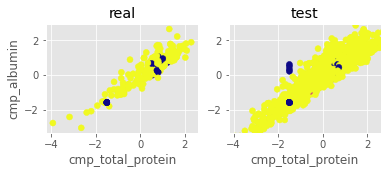

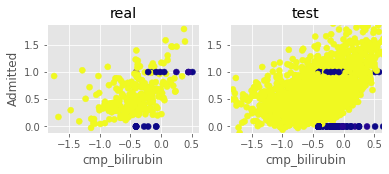

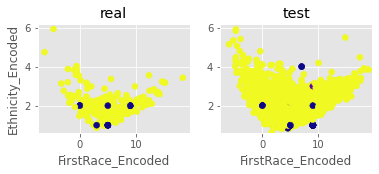

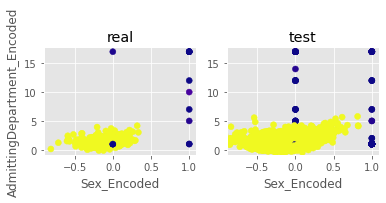

In [99]:
for i in range(0, len(X)-1, 2):
    fig, ax = plt.subplots(1, 2, figsize=(6,2))

    ax[0].scatter(test_gan[:n_real][X[i]], test_gan[:n_real][X[i + 1]], c=y_pred[:n_real], cmap='plasma')
    ax[0].set_title('real')
    ax[0].set_ylabel(X[i + 1])

    ax[1].scatter(test_gan[n_real:][X[i]], test_gan[n_real:][X[i + 1]], c=y_pred[n_real:], cmap='plasma')
    ax[1].set_title('test')
    ax[1].set_xlim(ax[0].get_xlim()), ax[1].set_ylim(ax[0].get_ylim())

    for a in ax:
        a.set_xlabel(X[i])

    plt.show()

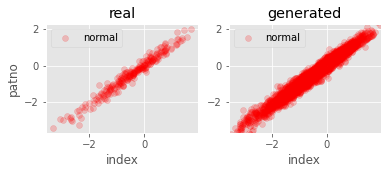

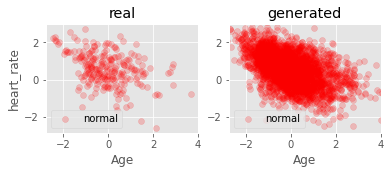

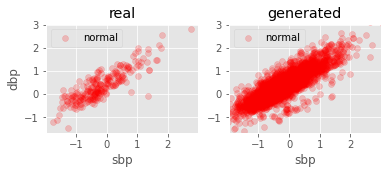

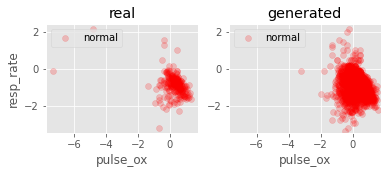

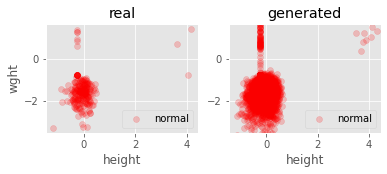

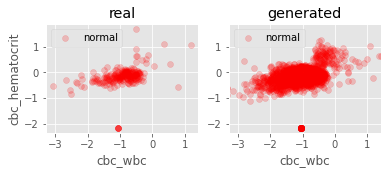

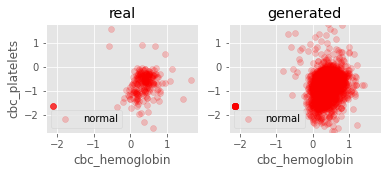

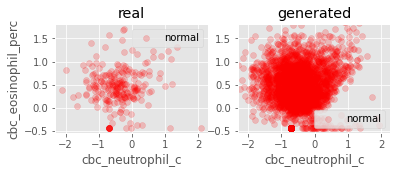

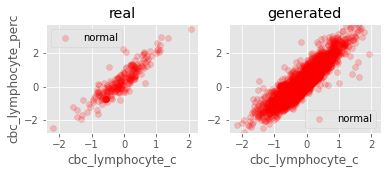

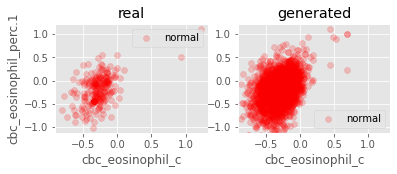

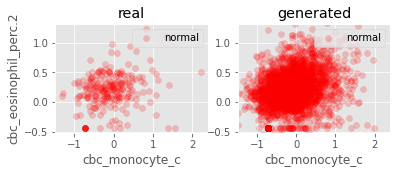

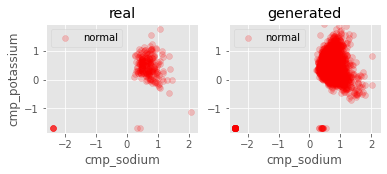

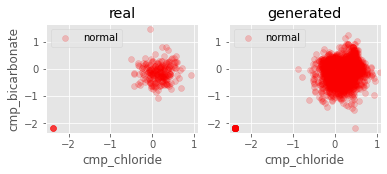

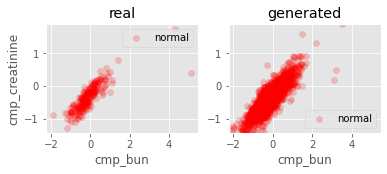

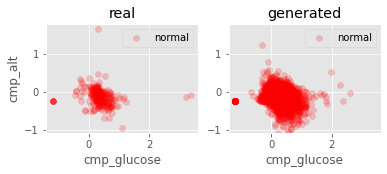

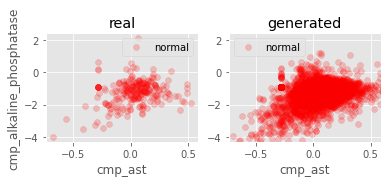

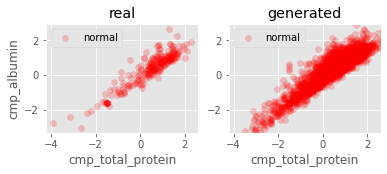

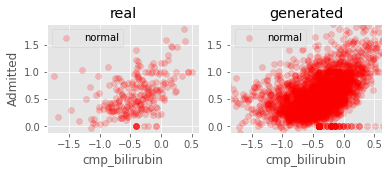

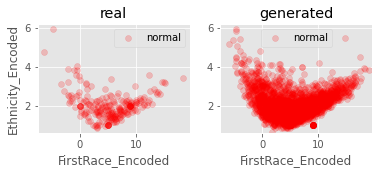

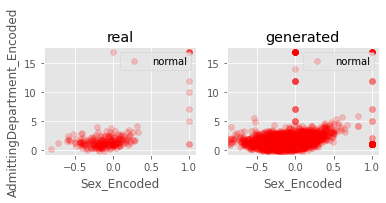

In [100]:
colors = ['red','blue']
markers = ['o','^']
labels = ['normal','detected']

target = 'COVIDResult_Encoded'

for i in range(0, len(X), 2):
    col1, col2 = i, i + 1
    if col2 >= len(X):
        continue
    
    fig, ax = plt.subplots(1, 2, figsize=(6,2))
    for group, color, marker, label in zip( test_gan[:n_real].groupby(target), colors, markers, labels):
        ax[0].scatter( group[1][X[col1]], group[1][X[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    ax[0].legend()
    ax[0].set_title('real')
    ax[0].set_ylabel(X[col2])

    for group, color, marker, label in zip( test_gan[n_real:].groupby(target), colors, markers, labels):
        ax[1].scatter(group[1][X[col1]], group[1][X[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    ax[1].set_xlim(ax[0].get_xlim()), ax[1].set_ylim(ax[0].get_ylim())
    ax[1].legend()
    ax[1].set_title('generated')

    for a in ax:
        a.set_xlabel(X[col1])

    plt.show()

#### 5.7 Feature Importance <a class="anchor" id="importance"></a>

In [101]:
MAX_FEATURES = 20

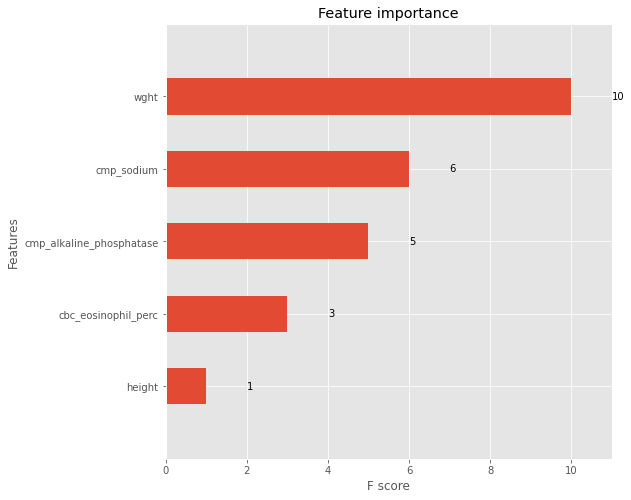

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_clf, max_num_features=MAX_FEATURES, height=0.5, ax=ax)
plt.show()

## 6. Retrain Models with GAN Data <a class="anchor" id="retrain"></a>

[Table of Contents](#toc)

#### 6.1 Re-Prepare Data <a class="anchor" id="prep2"></a>

In [103]:
real_data = final_data.copy()
fake_data = test.copy().drop(columns=['syn_label'])

In [104]:
combined = pd.concat([real_data, fake_data], axis=0)
combined = combined.sample(frac=1).reset_index(drop=True) # shuffle

In [105]:
combined.shape

(13490, 41)

In [106]:
retrain, retest = train_test_split(combined, test_size=0.5, random_state=SEED)

In [107]:
target = 'COVIDResult_Encoded'
X_cols = combined.columns.tolist()
X_cols.remove(target)

In [108]:
# NOTE: filter_ determines which input columns will be included in model training
#       TRUE: only the 12 knowledge-based features will be selected/included
#       FALSE: all features will be selected/included
filter_ = False

In [109]:
if filter_:
    X_cols = [
        'Age',
        'FirstRace_Encoded',
        'Ethnicity_Encoded',
        'Sex_Encoded',
        'height',
        'wght',
        'heart_rate',
        'sbp',
        'dbp',
        'pulse_ox',
        'resp_rate',
        'cmp_glucose'
    ]

In [110]:
X_retrain = retrain[X_cols]
y_retrain = retrain[target]
X_retest = retest[X_cols]
y_retest = retest[target]

In [111]:
X_retrain.shape

(6745, 40)

#### 6.2 Re-Train Models <a class="anchor" id="retrain2"></a>

**Metric Scores**

Accuracy: 96.43%
Precision: 98.26%
Recall: 94.36%
F1: 96.27%


**Confusion Matrix**

[[3392   55]
 [ 186 3112]]


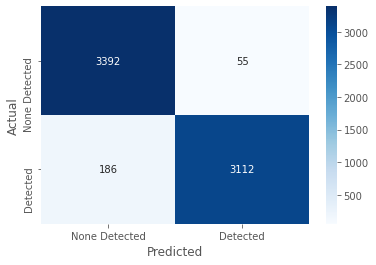

In [112]:
dt = DecisionTreeClassifier(
    max_depth=4, criterion="entropy", random_state=SEED
)
dt = dt.fit(X_retrain, y_retrain)
y_prediction = dt.predict(X_retest)
metric_evaluation(y_retest, y_prediction)
plot_confusion_matrix(y_retest, y_prediction)

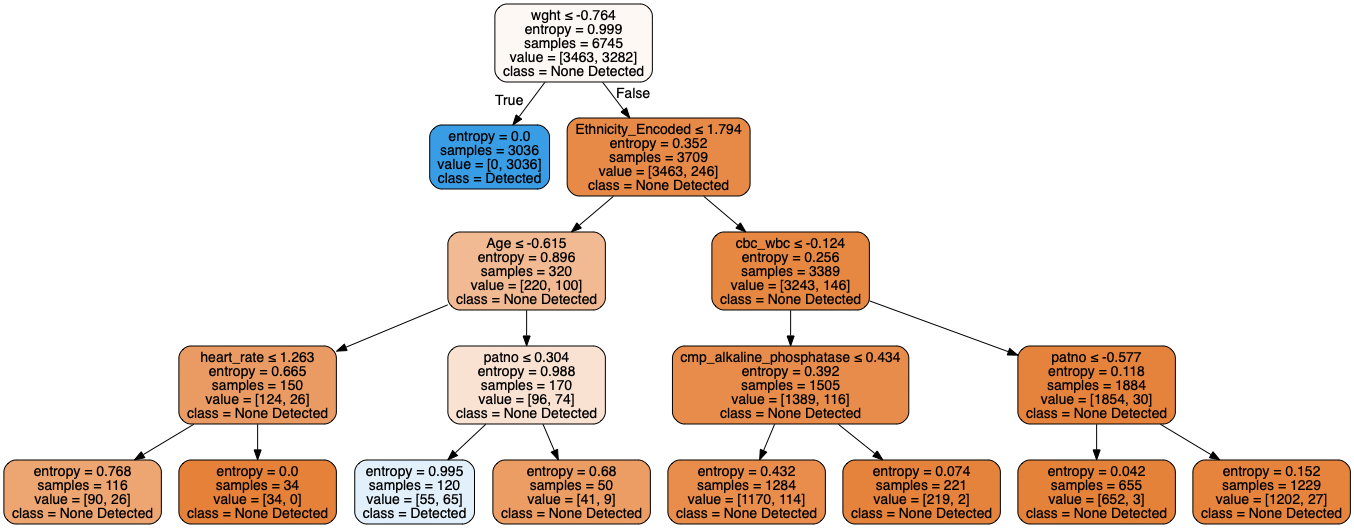

In [113]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_cols, class_names=['None Detected','Detected'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('rfc.png')
Image(graph.create_png())

In [114]:
# rfc = RandomForestClassifier(
#    n_estimators=100, bootstrap=True, max_features='sqrt', random_state=SEED
#)

**Metric Scores**

Accuracy: 96.55%
Precision: 100.00%
Recall: 92.94%
F1: 96.34%


**Confusion Matrix**

[[3447    0]
 [ 233 3065]]


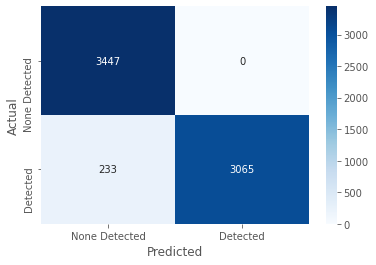

In [115]:
rfc = RandomForestClassifier(
    n_estimators=200, bootstrap=False, max_depth=5, max_features='auto',
    min_samples_leaf=1, min_samples_split=5, random_state=SEED
)
rfc.fit(X_retrain, y_retrain)
y_prediction = rfc.predict(X_retest)
metric_evaluation(y_retest, y_prediction)
plot_confusion_matrix(y_retest, y_prediction)

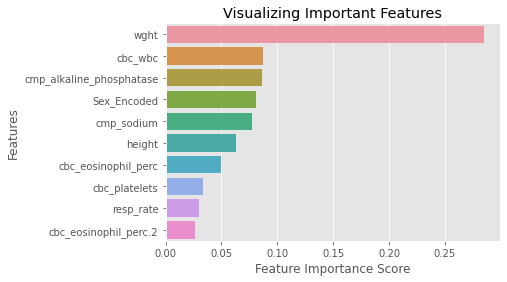

In [116]:
feature_importance = pd.Series(rfc.feature_importances_,index=X_cols).sort_values(ascending=False).iloc[:10]
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [117]:
params = {
    'bootstrap': [True, False],
    'max_depth': [3, 4, 5, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600]
}

In [118]:
# NOTE: run determines whether to conduct a Randomized Search for the RFC's best parameters
#       TRUE: Run the cross-validated randomized search
#       FALSE: do NOT run... avoid ~5 min run time
run = False

In [119]:
%%time
if run:
    rfc = RandomForestClassifier()
    rscv = RandomizedSearchCV(rfc, params, cv=3)
    best_rfc_model = rscv.fit(X_retrain, y_retrain)
    best_rfc_params = best_rfc_model.best_estimator_.get_params()
    
    print('Best bootstrap:', best_rfc_params['bootstrap'])
    print('Best max depth:', best_rfc_params['max_depth'])
    print('Best max_features:', best_rfc_params['max_features'])
    print('Best min_samples_leaf:', best_rfc_params['min_samples_leaf'])
    print('Best min_samples_split:', best_rfc_params['min_samples_split'])
    print('Best n_estimators:', best_rfc_params['n_estimators'])

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


**Metric Scores**

Accuracy: 96.68%
Precision: 99.84%
Recall: 93.36%
F1: 96.49%


**Confusion Matrix**

[[3442    5]
 [ 219 3079]]


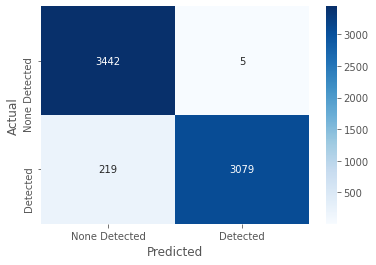

In [120]:
knn = KNeighborsClassifier(n_neighbors=14, p=1, leaf_size=1)
knn.fit(X_retrain, y_retrain)
y_prediction = knn.predict(X_retest)
metric_evaluation(y_retest, y_prediction)
plot_confusion_matrix(y_retest, y_prediction)

In [121]:
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
knn_2 = KNeighborsClassifier()

In [ ]:
# NOTE: run determines whether to conduct a Grid Search for the KNN's best parameters
#       TRUE: Run the cross-validated grid earch
#       FALSE: do NOT run... avoid ~5 min run time
run = False

In [122]:
%%time

if run:
    clf = GridSearchCV(knn_2, hyperparameters, cv=10)
    best_knn_model = clf.fit(X_retrain, y_retrain)
    best_knn_params = best_knn_model.best_estimator_.get_params()
    
    print('Best leaf_size:', best_knn_params['leaf_size'])
    print('Best p:', best_knn_params['p'])
    print('Best n_neighbors:', best_knn_params['n_neighbors'])

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 14.1 µs


### Model 1 – Deep Neural Network

**Summary**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
Total params: 1,178
Trainable params: 1,178
Non-trainable params: 0
______________________________________________________

**Training/Validation Loss and Accuracy**

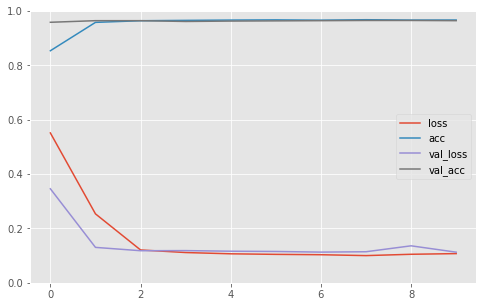

**Evaluation and Prediction**


Loss: 11.11%
Accuracy: 96.59%


**Metric Scores**

Accuracy: 96.59%
Precision: 99.84%
Recall: 93.18%
F1: 96.39%


**Confusion Matrix**

[[3442    5]
 [ 225 3073]]


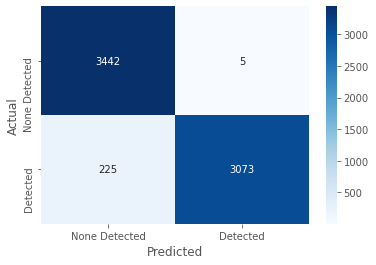

### Model 2 – Convolutional Neural Network

**Summary**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 1, 32)         320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 40, 1, 32)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 1, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 1, 64)         18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20, 1, 64)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 1, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 1, 128)       

**Training/Validation Loss and Accuracy**

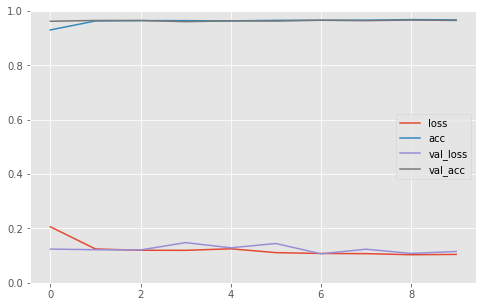

**Evaluation and Prediction**


Loss: 11.82%
Accuracy: 96.53%


**Metric Scores**

Accuracy: 96.53%
Precision: 99.84%
Recall: 93.06%
F1: 96.33%


**Confusion Matrix**

[[3442    5]
 [ 229 3069]]


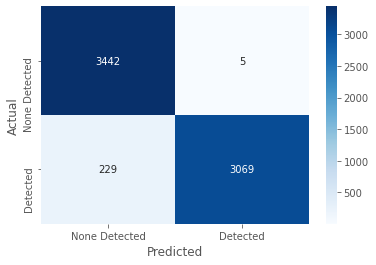

### Model 3 – Recurrent Neural Network

**Summary**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  16896     
_________________________________________________________________
dense_8 (Dense)              multiple                  130       
Total params: 17,026
Trainable params: 17,026
Non-trainable params: 0
_________________________________________________________________


**Training/Validation Loss and Accuracy**

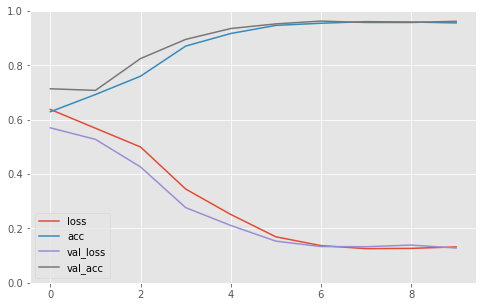

**Evaluation and Prediction**


Loss: 11.98%
Accuracy: 96.26%


**Metric Scores**

Accuracy: 96.26%
Precision: 99.48%
Recall: 92.84%
F1: 96.05%


**Confusion Matrix**

[[3431   16]
 [ 236 3062]]


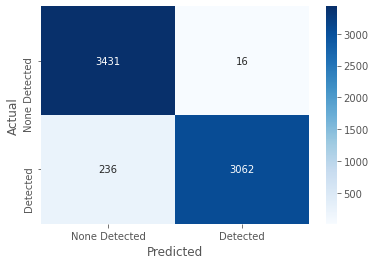


CPU times: user 2min 37s, sys: 33.8 s, total: 3min 11s
Wall time: 1min 22s


In [123]:
%%time
test_models([
    {'name': 'Deep Neural Network', 'model': dnn,
     'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-2),
     'binary': False, 'dims': 2},
    {'name': 'Convolutional Neural Network', 'model': cnn,
     'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-2),
     'binary': False, 'dims': 4},
    {'name': 'Recurrent Neural Network', 'model': rnn,
     'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-2),
     'binary': False, 'dims': 3}
], (X_retrain, y_retrain, X_retest, y_retest))

## 7. Final Model Training with Feature Selection <a class="anchor" id="final"></a>

[Table of Contents](#toc)

#### 7.1 Define Models and Variables <a class="anchor" id="define"></a>

In [124]:
models = [
    DecisionTreeClassifier(max_depth=4, criterion="entropy", random_state=SEED),
    RandomForestClassifier(n_estimators=100, bootstrap=True, max_features='sqrt', random_state=SEED),
    KNeighborsClassifier(n_neighbors=3),
    'Sequential',
    'Sequential',
    'Sequential'
]
names = [
    'Decision Tree Classifier',
    'Random Forest Classifier',
    'K-Nearest Neighbors Classifier',
    'Deep Neural Network',
    'Convolutional Neural Network',
    'Recurrent Neural Network'
]

In [125]:
for model in models:
    print(model)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=No

In [126]:
# NOTE: Order in which features are dropped, makes function run each model 5 times (len(drops)) 
drops = [
    ('sbp', 'dbp'),
    'pulse_ox',
    'cmp_glucose',
    'resp_rate',
    None
]

In [127]:
metrics = [
    'Accuracy',
    'Precision',
    'Recall',
    'F1'
]

In [128]:
EPOCHS = 30
BATCH_SIZE = 200
VAL_SPLIT = 0.2

In [129]:
def get_neural_net(num_cols, mName):
    '''
    test_final_models helper function, stores neural network models with dynamic inputs
    
    Parameters:
    - num_cols: number of features remainig
    - mName: model name
    
    Return:
    - m: model
    - d: number of dimensions for input layer (used to reshape)
    '''
    m = {
        'Deep Neural Network':
        Sequential([
            Dense(num_cols//2, activation='relu', input_shape=(num_cols,)),
            Dense(8, activation='relu'),
            Dense(8, activation='relu'),
            Dense(8, activation='relu'),
            Dense(4, activation='relu'),
            Dense(2, activation='softmax')
        ]),
        'Convolutional Neural Network':
        Sequential([
            Conv2D(32, kernel_size=(3, 3), input_shape=(num_cols, 1, 1), activation='linear', padding='same'),
            LeakyReLU(alpha=0.1),
            MaxPooling2D((2, 2), padding='same'),
            Conv2D(64, (3, 3), activation='linear',padding='same'),
            LeakyReLU(alpha=0.1),
            MaxPooling2D(pool_size=(2, 2), padding='same'),
            Conv2D(128, (3, 3), activation='linear',padding='same'),
            LeakyReLU(alpha=0.1),
            MaxPooling2D(pool_size=(2, 2), padding='same'),
            Flatten(),
            Dense(128, activation='linear'),
            LeakyReLU(alpha=0.1),
            Dense(2, activation='softmax')
        ]),
        'Recurrent Neural Network':
        Sequential([
            LSTM(64, dropout=0.2, recurrent_dropout=0.2),
            Dense(2, activation='softmax')
        ])
    }.get(mName)
    d = {
        'Deep Neural Network': 2,
        'Convolutional Neural Network': 4,
        'Recurrent Neural Network': 3
    }.get(mName)
    
    return m, d

In [130]:
def metric_evaluation2(y_test, y_pred):
    '''
    Metric evaluation helper, version 2; 
    Used to create final performance dataframes, rather than outputting to console
    
    Parameters:
    - y_test: array of test output column
    - y_pred: array of predicted output column
    
    Return: List of the four key performance metrics
    '''
    acc = round(accuracy_score(y_test, y_pred) * 100, 2)
    prec = round(precision_score(y_test, y_pred) * 100, 2)
    rec = round(recall_score(y_test, y_pred) * 100, 2)
    f1 = round(f1_score(y_test, y_pred) * 100, 2)
    return [acc, prec, rec, f1]

In [131]:
def test_final_models(models_lst, xy):
    '''
    30 iterations:
    
    For each iteration of feature selection (5):
        For each model in models_lst (6):
            0.5 Compile (only for NNs)
            1. Fit
            2. Predict
            3. Evaluate
    
    Parameters:
    - models_lst: list of models to be tested, combination of stored models and strings
    - xy: array of 4 elements: x_train, y_train, x_test, y_test
    
    Return: Dataframe of Model Performance Metrics
    '''
    X_train, y_train, X_test, y_test = xy
    X_cols = [
        'Age',
        'FirstRace_Encoded',
        'Ethnicity_Encoded',
        'Sex_Encoded',
        'height',
        'wght',
        'heart_rate',
        'sbp',
        'dbp',
        'pulse_ox',
        'resp_rate',
        'cmp_glucose'
    ]
    
    metric_scores_lst = []
    index_tuples = []
    
    for num, drop in enumerate(drops):
        display(Markdown('#### {} Features'.format(len(X_cols))))
        metric_scores = []
        
        for model, name in zip(models_lst, names):
            display(Markdown('<u>{}</u>'.format(name)))
            
            # NOTE: Necessary to account for dynamic input shape and extra compile step
            if model == 'Sequential':
                nn = True
                model, dims = get_neural_net(len(X_cols), name)
                model.compile(
                    loss='sparse_categorical_crossentropy',
                    optimizer=Adam(learning_rate=1e-2),
                    metrics=['accuracy']
                )
                
                X_train_arr = np.array(X_train[X_cols])
                shape = X_train_arr.shape
                if dims == 3:
                    X_train_arr = X_train_arr.reshape(shape[0], shape[1], 1)
                elif dims == 4:
                    X_train_arr = X_train_arr.reshape(shape[0], shape[1], 1, 1)
                
                model.fit(
                    X_train_arr, np.array(y_train),
                    batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VAL_SPLIT, shuffle=True, verbose=0
                )

            else:
                nn = False
                dims = 2
                model.fit(X_train[X_cols], y_train)
            
            X_test_arr = np.array(X_test[X_cols])
            shape = X_test_arr.shape
            if dims == 3:
                X_test_arr = X_test_arr.reshape(shape[0], shape[1], 1)
            elif dims == 4:
                X_test_arr = X_test_arr.reshape(shape[0], shape[1], 1, 1)
            
            y_prediction = model.predict(X_test_arr)
            y_prediction = np.argmax(y_prediction, axis=1) if nn else np.round(y_prediction)
            metric_evaluation(y_test, y_prediction, labels=False)
            
            metric_scores.extend(metric_evaluation2(y_test, y_prediction))
            if num == 0:
                for metric in metrics:
                    index_tuples.append((name, metric))
        
        metric_scores_lst.append(metric_scores)
        
        if drop is not None:
            if not isinstance(drop, str):
                X_cols.remove(drop[0])
                display(Markdown('*Dropping {}...*'.format(drop[0])))
                X_cols.remove(drop[1])
                display(Markdown('*Dropping {}...*'.format(drop[1])))
                
            else:
                X_cols.remove(drop)
                display(Markdown('*Dropping {}...*'.format(drop)))
           
    index = pd.MultiIndex.from_tuples(index_tuples, names=['Classifier', 'Scores'])
    transposed = map(list, zip(*metric_scores_lst))
    return pd.DataFrame(transposed, columns=['12', '10', '9', '8', '7'], index=index)

#### 7.2 Model Performance without GAN (Real Data) <a class="anchor" id="perf1"></a>

In [132]:
%%time
# ~ 5 min runtime
metric_df1 = test_final_models(models, (X_train, y_train, X_test, y_test))

#### 12 Features

<u>Decision Tree Classifier</u>

Accuracy: 93.70%
Precision: 46.67%
Recall: 7.61%
F1: 13.08%
[[1376    8]
 [  85    7]]


<u>Random Forest Classifier</u>

Accuracy: 94.11%
Precision: 77.78%
Recall: 7.61%
F1: 13.86%
[[1382    2]
 [  85    7]]


<u>K-Nearest Neighbors Classifier</u>

Accuracy: 92.89%
Precision: 29.03%
Recall: 9.78%
F1: 14.63%
[[1362   22]
 [  83    9]]


<u>Deep Neural Network</u>

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1384    0]
 [  92    0]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<u>Convolutional Neural Network</u>

Accuracy: 93.77%
Precision: 50.00%
Recall: 4.35%
F1: 8.00%
[[1380    4]
 [  88    4]]


<u>Recurrent Neural Network</u>

Accuracy: 93.77%
Precision: 50.00%
Recall: 2.17%
F1: 4.17%
[[1382    2]
 [  90    2]]


*Dropping sbp...*

*Dropping dbp...*

#### 10 Features

<u>Decision Tree Classifier</u>

Accuracy: 93.70%
Precision: 46.67%
Recall: 7.61%
F1: 13.08%
[[1376    8]
 [  85    7]]


<u>Random Forest Classifier</u>

Accuracy: 93.97%
Precision: 61.54%
Recall: 8.70%
F1: 15.24%
[[1379    5]
 [  84    8]]


<u>K-Nearest Neighbors Classifier</u>

Accuracy: 92.68%
Precision: 26.47%
Recall: 9.78%
F1: 14.29%
[[1359   25]
 [  83    9]]


<u>Deep Neural Network</u>

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1384    0]
 [  92    0]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<u>Convolutional Neural Network</u>

Accuracy: 93.70%
Precision: 40.00%
Recall: 2.17%
F1: 4.12%
[[1381    3]
 [  90    2]]


<u>Recurrent Neural Network</u>

Accuracy: 93.77%
Precision: 50.00%
Recall: 4.35%
F1: 8.00%
[[1380    4]
 [  88    4]]


*Dropping pulse_ox...*

#### 9 Features

<u>Decision Tree Classifier</u>

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1384    0]
 [  92    0]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<u>Random Forest Classifier</u>

Accuracy: 93.56%
Precision: 42.11%
Recall: 8.70%
F1: 14.41%
[[1373   11]
 [  84    8]]


<u>K-Nearest Neighbors Classifier</u>

Accuracy: 93.09%
Precision: 34.38%
Recall: 11.96%
F1: 17.74%
[[1363   21]
 [  81   11]]


<u>Deep Neural Network</u>

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1384    0]
 [  92    0]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<u>Convolutional Neural Network</u>

Accuracy: 93.77%
Precision: 50.00%
Recall: 2.17%
F1: 4.17%
[[1382    2]
 [  90    2]]


<u>Recurrent Neural Network</u>

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1384    0]
 [  92    0]]


*Dropping cmp_glucose...*

#### 8 Features

<u>Decision Tree Classifier</u>

Accuracy: 93.77%
Precision: 50.00%
Recall: 3.26%
F1: 6.12%
[[1381    3]
 [  89    3]]


<u>Random Forest Classifier</u>

Accuracy: 93.56%
Precision: 40.00%
Recall: 6.52%
F1: 11.21%
[[1375    9]
 [  86    6]]


<u>K-Nearest Neighbors Classifier</u>

Accuracy: 92.07%
Precision: 12.12%
Recall: 4.35%
F1: 6.40%
[[1355   29]
 [  88    4]]


<u>Deep Neural Network</u>

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1384    0]
 [  92    0]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<u>Convolutional Neural Network</u>

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1384    0]
 [  92    0]]


<u>Recurrent Neural Network</u>

Accuracy: 93.83%
Precision: 100.00%
Recall: 1.09%
F1: 2.15%
[[1384    0]
 [  91    1]]


*Dropping resp_rate...*

#### 7 Features

<u>Decision Tree Classifier</u>

Accuracy: 93.77%
Precision: 50.00%
Recall: 3.26%
F1: 6.12%
[[1381    3]
 [  89    3]]


<u>Random Forest Classifier</u>

Accuracy: 93.16%
Precision: 28.57%
Recall: 6.52%
F1: 10.62%
[[1369   15]
 [  86    6]]


<u>K-Nearest Neighbors Classifier</u>

Accuracy: 93.02%
Precision: 29.63%
Recall: 8.70%
F1: 13.45%
[[1365   19]
 [  84    8]]


<u>Deep Neural Network</u>

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1384    0]
 [  92    0]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<u>Convolutional Neural Network</u>

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1384    0]
 [  92    0]]


<u>Recurrent Neural Network</u>

Accuracy: 93.90%
Precision: 100.00%
Recall: 2.17%
F1: 4.26%
[[1384    0]
 [  90    2]]
CPU times: user 9min 23s, sys: 1min 55s, total: 11min 19s
Wall time: 5min 18s


In [133]:
metric_df1

12     10      9       8       7
Classifier                     Scores                                        
Decision Tree Classifier       Accuracy   93.70  93.70  93.77   93.77   93.77
                               Precision  46.67  46.67   0.00   50.00   50.00
                               Recall      7.61   7.61   0.00    3.26    3.26
                               F1         13.08  13.08   0.00    6.12    6.12
Random Forest Classifier       Accuracy   94.11  93.97  93.56   93.56   93.16
                               Precision  77.78  61.54  42.11   40.00   28.57
                               Recall      7.61   8.70   8.70    6.52    6.52
                               F1         13.86  15.24  14.41   11.21   10.62
K-Nearest Neighbors Classifier Accuracy   92.89  92.68  93.09   92.07   93.02
                               Precision  29.03  26.47  34.38   12.12   29.63
                               Recall      9.78   9.78  11.96    4.35    8.70
                               F1         14.63  14.29  17.74    6.40   13.45
Deep Neural Network            Accuracy   93.77  93.77  93.77   93.77   93.77
                               Precision   0.00   0.00   0.00    0.00    0.00
                               Recall      0.00   0.00   0.00    0.00    0.00
                               F1          0.00   0.00   0.00    0.00    0.00
Convolutional Neural Network   Accuracy   93.77  93.70  93.77   93.77   93.77
                               Precision  50.00  40.00  50.00    0.00    0.00
                               Recall      4.35   2.17   2.17    0.00    0.00
                               F1          8.00   4.12   4.17    0.00    0.00
Recurrent Neural Network       Accuracy   93.77  93.77  93.77   93.83   93.90
                               Precision  50.00  50.00   0.00  100.00  100.00
                               Recall      2.17   4.35   0.00    1.09    2.17
                               F1          4.17   8.00   0.00    2.15    4.26

#### 7.3 Model Performance with GAN <a class="anchor" id="perf2"></a>

In [134]:
%%time
# ~ 7 min runtime
metric_df2 = test_final_models(models, (X_retrain, y_retrain, X_retest, y_retest))

#### 12 Features

<u>Decision Tree Classifier</u>

Accuracy: 96.50%
Precision: 100.00%
Recall: 92.84%
F1: 96.29%
[[3447    0]
 [ 236 3062]]


<u>Random Forest Classifier</u>

Accuracy: 96.58%
Precision: 99.58%
Recall: 93.39%
F1: 96.39%
[[3434   13]
 [ 218 3080]]


<u>K-Nearest Neighbors Classifier</u>

Accuracy: 95.57%
Precision: 97.17%
Recall: 93.66%
F1: 95.38%
[[3357   90]
 [ 209 3089]]


<u>Deep Neural Network</u>

Accuracy: 96.17%
Precision: 99.61%
Recall: 92.54%
F1: 95.94%
[[3435   12]
 [ 246 3052]]


<u>Convolutional Neural Network</u>

Accuracy: 95.94%
Precision: 97.94%
Recall: 93.66%
F1: 95.75%
[[3382   65]
 [ 209 3089]]


<u>Recurrent Neural Network</u>

Accuracy: 96.37%
Precision: 99.16%
Recall: 93.36%
F1: 96.17%
[[3421   26]
 [ 219 3079]]


*Dropping sbp...*

*Dropping dbp...*

#### 10 Features

<u>Decision Tree Classifier</u>

Accuracy: 96.50%
Precision: 100.00%
Recall: 92.84%
F1: 96.29%
[[3447    0]
 [ 236 3062]]


<u>Random Forest Classifier</u>

Accuracy: 96.44%
Precision: 99.26%
Recall: 93.42%
F1: 96.25%
[[3424   23]
 [ 217 3081]]


<u>K-Nearest Neighbors Classifier</u>

Accuracy: 95.85%
Precision: 97.81%
Recall: 93.60%
F1: 95.66%
[[3378   69]
 [ 211 3087]]


<u>Deep Neural Network</u>

Accuracy: 96.12%
Precision: 98.72%
Recall: 93.27%
F1: 95.92%
[[3407   40]
 [ 222 3076]]


<u>Convolutional Neural Network</u>

Accuracy: 96.00%
Precision: 98.16%
Recall: 93.57%
F1: 95.81%
[[3389   58]
 [ 212 3086]]


<u>Recurrent Neural Network</u>

Accuracy: 96.22%
Precision: 99.51%
Recall: 92.72%
F1: 96.00%
[[3432   15]
 [ 240 3058]]


*Dropping pulse_ox...*

#### 9 Features

<u>Decision Tree Classifier</u>

Accuracy: 96.50%
Precision: 100.00%
Recall: 92.84%
F1: 96.29%
[[3447    0]
 [ 236 3062]]


<u>Random Forest Classifier</u>

Accuracy: 96.50%
Precision: 99.42%
Recall: 93.39%
F1: 96.31%
[[3429   18]
 [ 218 3080]]


<u>K-Nearest Neighbors Classifier</u>

Accuracy: 95.69%
Precision: 97.62%
Recall: 93.45%
F1: 95.49%
[[3372   75]
 [ 216 3082]]


<u>Deep Neural Network</u>

Accuracy: 96.32%
Precision: 99.58%
Recall: 92.87%
F1: 96.11%
[[3434   13]
 [ 235 3063]]


<u>Convolutional Neural Network</u>

Accuracy: 96.35%
Precision: 99.74%
Recall: 92.78%
F1: 96.14%
[[3439    8]
 [ 238 3060]]


<u>Recurrent Neural Network</u>

Accuracy: 96.04%
Precision: 99.67%
Recall: 92.21%
F1: 95.79%
[[3437   10]
 [ 257 3041]]


*Dropping cmp_glucose...*

#### 8 Features

<u>Decision Tree Classifier</u>

Accuracy: 96.50%
Precision: 100.00%
Recall: 92.84%
F1: 96.29%
[[3447    0]
 [ 236 3062]]


<u>Random Forest Classifier</u>

Accuracy: 96.41%
Precision: 99.16%
Recall: 93.45%
F1: 96.22%
[[3421   26]
 [ 216 3082]]


<u>K-Nearest Neighbors Classifier</u>

Accuracy: 95.67%
Precision: 97.81%
Recall: 93.24%
F1: 95.47%
[[3378   69]
 [ 223 3075]]


<u>Deep Neural Network</u>

Accuracy: 96.01%
Precision: 99.77%
Recall: 92.06%
F1: 95.76%
[[3440    7]
 [ 262 3036]]


<u>Convolutional Neural Network</u>

Accuracy: 96.19%
Precision: 99.22%
Recall: 92.94%
F1: 95.98%
[[3423   24]
 [ 233 3065]]


<u>Recurrent Neural Network</u>

Accuracy: 96.19%
Precision: 98.75%
Recall: 93.39%
F1: 96.00%
[[3408   39]
 [ 218 3080]]


*Dropping resp_rate...*

#### 7 Features

<u>Decision Tree Classifier</u>

Accuracy: 96.50%
Precision: 100.00%
Recall: 92.84%
F1: 96.29%
[[3447    0]
 [ 236 3062]]


<u>Random Forest Classifier</u>

Accuracy: 96.31%
Precision: 98.91%
Recall: 93.48%
F1: 96.12%
[[3413   34]
 [ 215 3083]]


<u>K-Nearest Neighbors Classifier</u>

Accuracy: 95.70%
Precision: 97.78%
Recall: 93.33%
F1: 95.50%
[[3377   70]
 [ 220 3078]]


<u>Deep Neural Network</u>

Accuracy: 96.20%
Precision: 98.75%
Recall: 93.42%
F1: 96.01%
[[3408   39]
 [ 217 3081]]


<u>Convolutional Neural Network</u>

Accuracy: 96.29%
Precision: 99.80%
Recall: 92.60%
F1: 96.07%
[[3441    6]
 [ 244 3054]]


<u>Recurrent Neural Network</u>

Accuracy: 96.22%
Precision: 99.06%
Recall: 93.15%
F1: 96.02%
[[3418   29]
 [ 226 3072]]
CPU times: user 11min 29s, sys: 2min 16s, total: 13min 46s
Wall time: 7min 3s


In [135]:
metric_df2

12      10       9       8  \
Classifier                     Scores                                      
Decision Tree Classifier       Accuracy    96.50   96.50   96.50   96.50   
                               Precision  100.00  100.00  100.00  100.00   
                               Recall      92.84   92.84   92.84   92.84   
                               F1          96.29   96.29   96.29   96.29   
Random Forest Classifier       Accuracy    96.58   96.44   96.50   96.41   
                               Precision   99.58   99.26   99.42   99.16   
                               Recall      93.39   93.42   93.39   93.45   
                               F1          96.39   96.25   96.31   96.22   
K-Nearest Neighbors Classifier Accuracy    95.57   95.85   95.69   95.67   
                               Precision   97.17   97.81   97.62   97.81   
                               Recall      93.66   93.60   93.45   93.24   
                               F1          95.38   95.66   95.49   95.47   
Deep Neural Network            Accuracy    96.17   96.12   96.32   96.01   
                               Precision   99.61   98.72   99.58   99.77   
                               Recall      92.54   93.27   92.87   92.06   
                               F1          95.94   95.92   96.11   95.76   
Convolutional Neural Network   Accuracy    95.94   96.00   96.35   96.19   
                               Precision   97.94   98.16   99.74   99.22   
                               Recall      93.66   93.57   92.78   92.94   
                               F1          95.75   95.81   96.14   95.98   
Recurrent Neural Network       Accuracy    96.37   96.22   96.04   96.19   
                               Precision   99.16   99.51   99.67   98.75   
                               Recall      93.36   92.72   92.21   93.39   
                               F1          96.17   96.00   95.79   96.00   

                                               7  
Classifier                     Scores             
Decision Tree Classifier       Accuracy    96.50  
                               Precision  100.00  
                               Recall      92.84  
                               F1          96.29  
Random Forest Classifier       Accuracy    96.31  
                               Precision   98.91  
                               Recall      93.48  
                               F1          96.12  
K-Nearest Neighbors Classifier Accuracy    95.70  
                               Precision   97.78  
                               Recall      93.33  
                               F1          95.50  
Deep Neural Network            Accuracy    96.20  
                               Precision   98.75  
                               Recall      93.42  
                               F1          96.01  
Convolutional Neural Network   Accuracy    96.29  
                               Precision   99.80  
                               Recall      92.60  
                               F1          96.07  
Recurrent Neural Network       Accuracy    96.22  
                               Precision   99.06  
                               Recall      93.15  
                               F1          96.02

## 8. Figures for Final Report <a class="anchor" id="figures"></a>

[Table of Contents](#toc)

In [136]:
initial = [
    'Age',
    'FirstRace_Encoded',
    'Ethnicity_Encoded',
    'Sex_Encoded',
    'height',
    'wght',
    'heart_rate',
    'sbp',
    'dbp',
    'pulse_ox',
    'resp_rate',
    'cmp_glucose'
]
final = [
    'Age',
    'FirstRace_Encoded',
    'Ethnicity_Encoded',
    'Sex_Encoded',
    'height',
    'wght',
    'heart_rate'
]

In [137]:
groups = []
for i in range(len(final)):
        for j in range(len(final) - 1):
            try:
                x, y = final[i], final[i+j+1]
                groups.append([x, y])
            except IndexError:
                continue

In [138]:
locs = []
for i in range(3):
    for j in range(7):
        locs.append([i, j])

In [139]:
# NOTE: plot determines whether to create 7X3 grid of KNN plots
#       TRUE: Create the plot
#       FALSE: do NOT run/create plot... avoid ~10 min run time
plot = False

In [140]:
%%time

if plot:
    plt.rcParams.update({'font.size': 8})
    gs = gridspec.GridSpec(3, 7)
    fig = plt.figure(figsize=(25,10))

    for xy, gxy in zip(groups, locs):
        X, y = xy
        knn = KNeighborsClassifier(n_neighbors=3)   # for simplicity
        knn.fit(X_retrain[xy], y_retrain)
        ax = plt.subplot(gs[gxy[0], gxy[1]])
        fig = plot_decision_regions(
            X=np.array(X_retrain[xy]),
            y=np.array(y_retrain).astype(np.integer), clf=knn, legend=2
        )
        plt.title('{} vs {}'.format(y, X))

    plt.show()

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


In [141]:
dt = DecisionTreeClassifier(
    max_depth=4, criterion="entropy", random_state=SEED
)
dt = dt.fit(X_retrain[final], y_retrain)

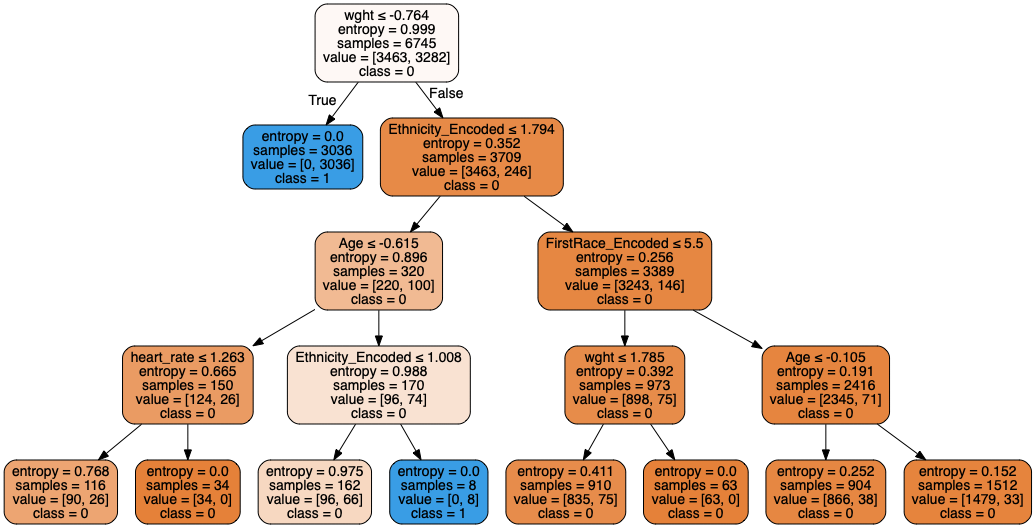

In [142]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=final, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('rfc.png')
Image(graph.create_png())

In [143]:
# NOTE: Commented out because the function creates and opens PDF file on computer;
#       used once for report (neural network visual)

# ann_viz(dnn)